In [1]:
import importlib
%reload_ext autoreload
%autoreload
%matplotlib inline

import sys
sys.path.append('/disk/bifrost/yuanze/software/KcwiKit/py')
import os
import kcwi
import pdb


import kcwi_tools
import common_tools_yd
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import SymLogNorm
import scienceplots
from matplotlib import gridspec
import matplotlib.patches as mpatches
import cmcrameri as SCM7

import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.cosmology import Planck18, FlatLambdaCDM
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel

from importlib import reload
from spectral_cube import SpectralCube
from reproject import reproject_interp
from regions import Regions
import linetools

from scipy import interpolate
def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 10*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, norm = norm, cmap = cmap)
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    return fig, ax, im

def imshow_ifu(img, wcsinfo=None,pix_scale=[0.3,0.3], redshift=0. , figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None),dpi=300):
    scale_kpc_per_arcsec = Planck18.kpc_proper_per_arcmin(redshift).value / 60.0
    _, med, std = sigma_clipped_stats(img.data)

    fig =  plt.figure(figsize = figsize,dpi=dpi)
    
    if wcsinfo is not None:
        
        ax = plt.subplot(projection=wcsinfo)
    else:
        ax = plt.subplot()
    
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 6*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, origin='lower', norm = norm, cmap = cmap)
    # Determine pixel scales in arcseconds
    if wcsinfo is not None:
        pix_scale_ra = np.abs(wcsinfo.pixel_scale_matrix[0,0]) * 3600.0  # RA scale in arcsec/pixel
        pix_scale_dec = np.abs(wcsinfo.pixel_scale_matrix[1,1]) * 3600.0  # Dec scale in arcsec/pixel
    elif pix_scale is not None:
        pix_scale_ra=pix_scale[0]
        pix_scale_dec=pix_scale[1]
    else:
        pix_scale_ra=None
        pix_scale_dec=None

    # Convert to physical scales
    #pix_scale_ra_kpc = pix_scale_ra * scale_kpc_per_arcsec
    #pix_scale_dec_kpc = pix_scale_dec * scale_kpc_per_arcsec
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    x = np.linspace(0, img.shape[1], 8)
    y = np.linspace(0, img.shape[0], 8)
#    x_labels_kpc = x * pix_scale_ra_kpc
#    y_labels_kpc = y * pix_scale_dec_kpc
    x_labels_arcsec = x * pix_scale_ra
    y_labels_arcsec = y * pix_scale_dec
    # Setting direction arrows
    x0, y0 = 85, 85
    arrow_length = 10

    # North arrow goes upward in y-direction (positive Dec)
    ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='white', label='North')
    ax.text(x0-2, y0+1, 'N', color='white', ha='center', va='bottom')
    # East arrow goes to the right in x-direction (negative RA)
    ax.quiver(x0, y0, arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='white', label='East')
    ax.text(x0+2, y0-1, 'E', color='white', ha='center', va='top')

#    print(ra,dec)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(np.round(x_labels_arcsec-np.mean(x_labels_arcsec),decimals=1))
    ax.set_yticklabels(np.round(y_labels_arcsec-np.mean(y_labels_arcsec),decimals=1))
    ax.set_xlabel(r"$\Delta$arcsec")
    ax.set_ylabel(r"$\Delta$arcsec")
    return fig, ax

mycosmos=FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
KBSSpath="/disk/bifrost/yuanze/KBSS"

## Testing different implementation of radial profile 

In [ ]:
#cubename="Q1217"
#sourcename="BX172"
psname="BX160"

#redshift=2.6347
#RA=184.91584
#DEC=49.66657


qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
sentry=qsos[qsos["Name"]==psname]
sourcename=sentry["Cube"].value[0]
cubename=sentry["Field"].value[0]
Type=sentry["Type"][0]
if sentry["zneb"]>0:
    redshift=sentry["zneb"].value[0]
elif sentry["zabs"]>0:
    redshift=sentry["zabs"].value[0]
else:
    redshift=sentry["zlya"].value[0]
RA = sentry["RA"].value[0]
DEC = sentry["Dec"].value[0]
xpix = sentry["x"].value[0]
ypix = sentry["y"].value[0]

datapath=KBSSpath+"/"+cubename+"/"+sourcename
subdapath=KBSSpath+"/"+cubename+"/"+psname

cubefile = datapath+"/kcwi_oned/{}-{}_icubes_wcs.fits".format(cubename.lower(),sourcename)

if Type=='QSO' or Type=='AGN/QSO':
    Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
else:
    Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.CONTSub.fits".format(cubename.lower(),psname)


#

interpolating with grid:  (2602,) (50,) on (2602, 50)


/disk/bifrost/yuanze/anaconda3/envs/kcwidrp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


Text(0, 0.5, 'SB $\\rm (10^{-16}~erg~s^{-1}~cm^{-2}~arcsec^{-2})$')

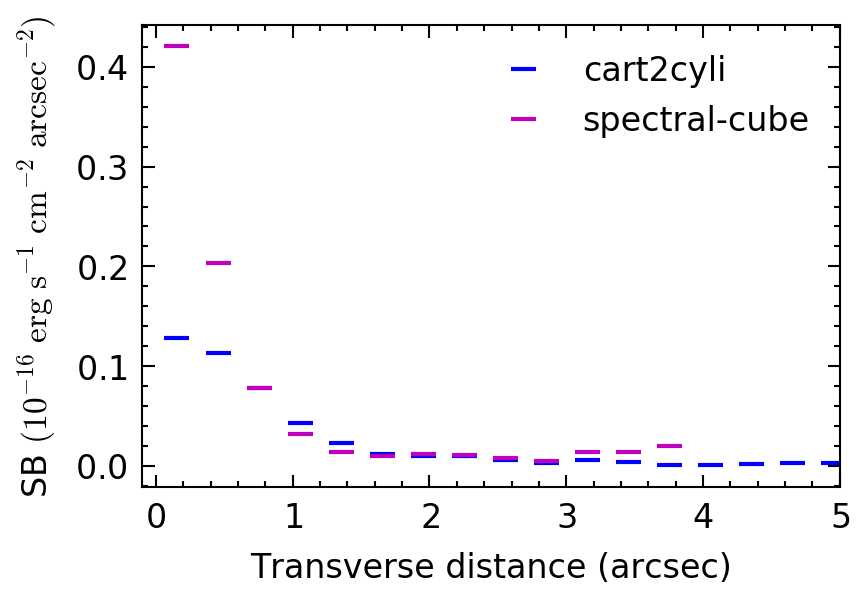

In [129]:
from scipy import interpolate

fn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli.fits".format(cubename.lower(),psname)
afn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli_area.fits".format(cubename.lower(),psname)
hdu = fits.open(fn)[0]
hdr = hdu.header

#adata = fits.open(afn)[0].data
cw=1216.9 # central wavelength
wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
vc = (wc / (1 + redshift) - cw) / cw *3e5
dc = (np.arange(hdr['NAXIS2']) - hdr['CRPIX2'] + 1) * hdr['CD2_2'] + hdr['CRVAL2']

#am2d=np.nansum(adata,axis=2)
m2d=np.nanmean(hdu.data,axis=2)
print("interpolating with grid: ",vc.shape,dc.shape,"on",m2d.shape)
#interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
#r = interpolate.RectBivariateSpline(vc, dc, np.nan_to_num(m2d))

#interpfunc = lambda xnew, ynew: r(xnew, ynew).T

#interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
#xstack = np.arange(-1600, 2000, 50)
#ystack = np.arange(0, 25., 0.1)


#cp2d_new = interpfunc(xstack,ystack)




index_b = (vc > -1000) & (vc <= 0)
index_r = (vc > 0) & (vc <= 1200)
index_a = (vc > -1000) & (vc <= 1200)

sb_b0 = np.sum(m2d[index_b, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)
sb_r0 = np.sum(m2d[index_r, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)
sb_a0 = np.sum(m2d[index_a, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)

#asb_a0 = np.sum(am2d[index_a, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)

fig, ax = plt.subplots(figsize=(3,2),dpi=300)

ax.errorbar(dc,sb_b0
            ,fmt="_",
        label="cart2cyli",
        color="b",
        capsize=0.0,
        ls="None",
        lw=1)
ty=np.array([42.11899788, 20.3189102 ,  7.77915837,  3.14462739,  1.38252179,
        1.00454077,  1.1575351 ,  1.10231811,  0.79644328,  0.46233536,
        1.36576262,  1.39187972,  1.94364115,         np.nan,         np.nan,
               np.nan,         np.nan,         np.nan,         np.nan])
rbin=np.array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6, 3.9,
       4.2, 4.5, 4.8, 5.1, 5.4, 5.7])
ax.errorbar(rbin-0.15,ty*0.01
            ,fmt="_",
        label="spectral-cube",
        color='m',
        capsize=0.0,
        ls="None",
        lw=1)
#ax.plot(rbin[:-1]*kpc_per_arcsec+rx/2,np.array(annulus_value[sourcename][1])*2,color="k")

#ax.fill_between(rbin[:-1]*kpc_per_arcsec+rx/2,0,np.array(annulus_value[sourcename][1])*2,color="k",alpha=0.3)

#x_fit = np.linspace(3, 20, 100)
#y_fit=fitted_model(x_fit)
#ax.plot(x_fit,y_fit,"g")
ax.legend()
#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([-0.1,5])
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel("Transverse distance (arcsec)")
ax.set_ylabel(r"SB $\rm (10^{-16}~erg~s^{-1}~cm^{-2}~arcsec^{-2})$")
#fig.savefig(KBSSpath+"/"+field+"/"+sourcename+"/kcwi_oned/SB_profile.pdf")


# 1. reproject PSF subtracted cube onto cylindrical system

In [245]:
from importlib import reload
reload(kcwi_tools)
#dkind=".PSFCONTSub"
overwrite=True
dkind=""
for psname in ["BX160"]:#enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if True:#Type=='QSO' or Type=='AGN/QSO':
        subdapath=KBSSpath+"/"+cubename+"/"+psname
        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs{}.fits".format(cubename.lower(),psname,dkind)
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
    else:
        print(psname,"is not type-1, skipping...")
        continue
    writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli.fits".format(cubename.lower(),psname)
    if overwrite==True or (not os.path.exists(writefn)):
        print("reprojecting",psname,"to cylindrical system...")
        hdu=fits.open(Subfile)
        hdu2=fits.open(cubefile)
        hdu[0].header["CNAME3"]=hdu2[0].header["CNAME3"]
        nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],r_range=[0,15],writefn=writefn,montage=False,montagepy=False,clean=False)
    else:
        print("reprojected cube existed: no stacking performed ")


reprojecting BX160 to cylindrical system...


In [749]:
ypix,xpix

(42.25, 64.47)

### Do the same for HL QSOs

In [697]:
qsos_bright=ascii.read(KBSSpath+"/KCWI/qsos_bright.kcwi",format="ipac")
i=0
dryrun=False
for ind,field in enumerate(qsos_bright['Field']):
    sentry=qsos_bright[qsos_bright["Field"]==field]
    #cubename=sentry["Field"].value[0]
    #Type=sentry["Type"][0]
    if field=="1623":
        psname=sentry["Name"][i].split("-")[1]
        i+=1
        sentry=qsos_bright[(qsos_bright["Field"]==field) & (qsos_bright["Name"]==field+"-"+psname)]
        ssentry=qsos[qsos["Name"]==psname]
        csname=ssentry["Cube"][0]
        dapath=KBSSpath+"/"+field+"/"+csname+"/kcwi_oned"
        subdapath=KBSSpath+"/"+field+"/"+psname+"/kcwi_oned"
        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.fits".format(field.lower(),psname)
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
        writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli.fits".format(field.lower(),psname)
    else:
        subdapath=KBSSpath+"/"+field+"/QSO"
        Subfile = subdapath+"/{}-qso_icubes_wcs.fits".format(field.lower())
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
        writefn=subdapath+"/{}-qso_icubes_wcs.sat.cyli.fits".format(field.lower())
    if not os.path.exists(writefn):
        print("reprojecting",sentry["Name"][0],"to cylindrical system...")
        print("reading:",Subfile)
        print("writing result to ",writefn)
        if dryrun:
            continue
        hdu=fits.open(Subfile)
        hdu[0].header["CNAME3"]='KCWI Wavelength'
        nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],r_range=[0,15],writefn=writefn)
    else:
        print("reprojected cube existed: no stacking performed ")


reprojecting Q0100+13 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0100/QSO/q0100-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0100/QSO/q0100-qso_icubes_wcs.sat.cyli.fits
reprojecting HS0105+1619 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0105/QSO/q0105-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0105/QSO/q0105-qso_icubes_wcs.sat.cyli.fits
reprojecting Q0142-10 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0142/QSO/q0142-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0142/QSO/q0142-qso_icubes_wcs.sat.cyli.fits
reprojecting Q0207-003 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0207/QSO/q0207-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0207/QSO/q0207-qso_icubes_wcs.sat.cyli.fits
reprojecting Q0821+3107 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0821/QSO/q0821-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS

FileNotFoundError: [Errno 2] No such file or directory: '/disk/bifrost/yuanze/KBSS/Q1623/QSO/q1623-qso_icubes_wcs.fits'

In [241]:
hdu=fits.open(Subfile)
hdu2=fits.open(cubefile)
hdu[0].header["CNAME3"]=hdu2[0].header["CNAME3"]
nhdu=kcwi_tools.cart2cyli(hdu2[0],[xpix,ypix],r_range=[0,10],clean=False,montage=True,montagepy=True)

maximum of data5: nan


In [234]:
testhdr=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_3.fits")

In [417]:
print(np.nanmax(testhdr[0].data))
print(np.nanmax(nhdu[0].data))

2.7166420655036454
49.22491697470347


In [231]:

hdu3_1=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_1.fits")[0]
hdu3_2=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_2.fits")[0]
hdu3_3=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_3.fits")[0]

data4=np.zeros((hdu3_1.shape[0],hdu3_1.shape[1],
                hdu3_1.shape[2]+hdu3_2.shape[2]+hdu3_3.shape[2]-30))
data4[:,:,0:hdu3_1.shape[2]-10]=hdu3_1.data[:,:,5:hdu3_1.shape[2]-5]
data4[:,:,hdu3_1.shape[2]-10:
        hdu3_1.shape[2]+hdu3_2.shape[2]-20]=hdu3_2.data[:,:,5:hdu3_2.shape[2]-5]
data4[:,:,hdu3_1.shape[2]+hdu3_2.shape[2]-20:
        hdu3_1.shape[2]+hdu3_2.shape[2]+hdu3_3.shape[2]-30]=hdu3_3.data[:,:,5:hdu3_3.shape[2]-5]
data4[data4==0]=np.nan

In [239]:
hdu3_3.shape[2]

130

In [233]:
dx=-hdu3_1.header['CD1_1']
dx0=-nhdu[0].header['CD1_1']
print(int(dx0/dx))
print(nhdu[0].header['CRVAL2'])

1
0


# 2. Stack cube together 

In [ ]:
for ind,psname in enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if Type=='QSO' or Type=='AGN/QSO':

In [318]:
sourcename="BX172"
psname="BX164"

qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
sentry=qsos[qsos["Name"]==psname]
cubename=sentry["Field"].value[0]
Type=sentry["Type"][0]
if sentry["zneb"]>0:
    redshift=sentry["zneb"].value[0]
elif sentry["zabs"]>0:
    redshift=sentry["zabs"].value[0]
else:
    redshift=sentry["zlya"].value[0]
RA = sentry["RA"].value[0]
DEC = sentry["Dec"].value[0]
xpix = sentry["x"].value[0]
ypix = sentry["y"].value[0]

datapath=KBSSpath+"/"+cubename+"/"+sourcename
subdapath=KBSSpath+"/"+cubename+"/"+psname

cyli_cube=fits.open(subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname))

In [319]:
def create_axis(header, crval, cdelt, naxis):
    return np.arange(header[crval], header[crval] + cdelt * header[naxis], cdelt)


PA_axis=np.arange(cyli_cube[0].header['CRVAL1A'],cyli_cube[0].header['CRVAL1A']+cyli_cube[0].header['CD1_1A']*(cyli_cube[0].header['NAXIS1']),cyli_cube[0].header['CD1_1A'])
r_axis=np.arange(cyli_cube[0].header['CRVAL2A'],cyli_cube[0].header['CRVAL2A']+cyli_cube[0].header['CD2_2A']*(cyli_cube[0].header['NAXIS2']),cyli_cube[0].header['CD2_2A'])
spec_axis=np.arange(cyli_cube[0].header['CRVAL3A'],cyli_cube[0].header['CRVAL3A']+cyli_cube[0].header['CD3_3A']*(cyli_cube[0].header['NAXIS3']),cyli_cube[0].header['CD3_3A'])

In [352]:
coord=["01 03 11.27 +13 16 18.2",\
      "01 08 06.4  +16 35 50.0",\
       "01 45 16.6  -09 45 17.0",\
       "02 09 50.71 -00 05 06.5",\
       "04 52 14.3  -16 40 16.2",\
       "08 21 07.62 +31 07 51.17",\
       "10 11 55.60 +29 41 41.7",\
       "12 19 30.85 +49 40 51.2",\
       "14 44 53.67 +29 19 05.6",\
       "15 51 52.5  +19 11 04.3",\
       "16 04 55.38 +38 12 01.8",\
       "16 25 48.83 +26 46 58.8",\
       "16 25 48.1  +26 44 32.9",\
       "16 25 57.4  +26 44 48.5",\
       "17 01 00.6  +64 12 09.4",\
       "22 08 52.1  -19 43 59.7",\
       "23 46 28.30 +12 48 57.8"
      ]
for pos in coord:
    s=SkyCoord(pos,unit=(u.hourangle, u.deg))
    print(s)

<SkyCoord (ICRS): (ra, dec) in deg
    (15.79695833, 13.27172222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (17.02666667, 16.59722222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (26.31916667, -9.75472222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (32.46129167, -0.08513889)>
<SkyCoord (ICRS): (ra, dec) in deg
    (73.05958333, -16.67116667)>
<SkyCoord (ICRS): (ra, dec) in deg
    (125.28175, 31.13088056)>
<SkyCoord (ICRS): (ra, dec) in deg
    (152.98166667, 29.69491667)>
<SkyCoord (ICRS): (ra, dec) in deg
    (184.87854167, 49.68088889)>
<SkyCoord (ICRS): (ra, dec) in deg
    (221.223625, 29.31822222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (237.96875, 19.18452778)>
<SkyCoord (ICRS): (ra, dec) in deg
    (241.23075, 38.2005)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.45345833, 26.783)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.45041667, 26.74247222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.48916667, 26.74680556)>
<SkyCoord (ICRS): (ra, dec) in deg
    (255.2525, 64.20261111)>
<SkyCoor

In [99]:
wdir=f"{KBSSpath}/stack_analysis"
flist=[]
for ind,psname in enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if Type=='QSO' or Type=='AGN/QSO':
        subdapath=KBSSpath+"/"+cubename+"/"+psname
#        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
        cyli_cube_name=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname)
        flist.append(cyli_cube_name)
#np.savetxt(wdir+"/source.list",np.array(flist).T,fmt='%s')

In [65]:
Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
Sub_cube = SpectralCube.read(Subfile)

In [339]:
QSOtab=qsos[((qsos['Type']=="QSO")|(qsos['Type']=="AGN/QSO"))& (qsos['R']>21)&(qsos['ext']=="True")]#&

In [340]:
result=stack_cp2d(QSOtab)

interpolating with grid:  (2599,) (50,) on (2599, 50)
interpolating with grid:  (2597,) (50,) on (2597, 50)


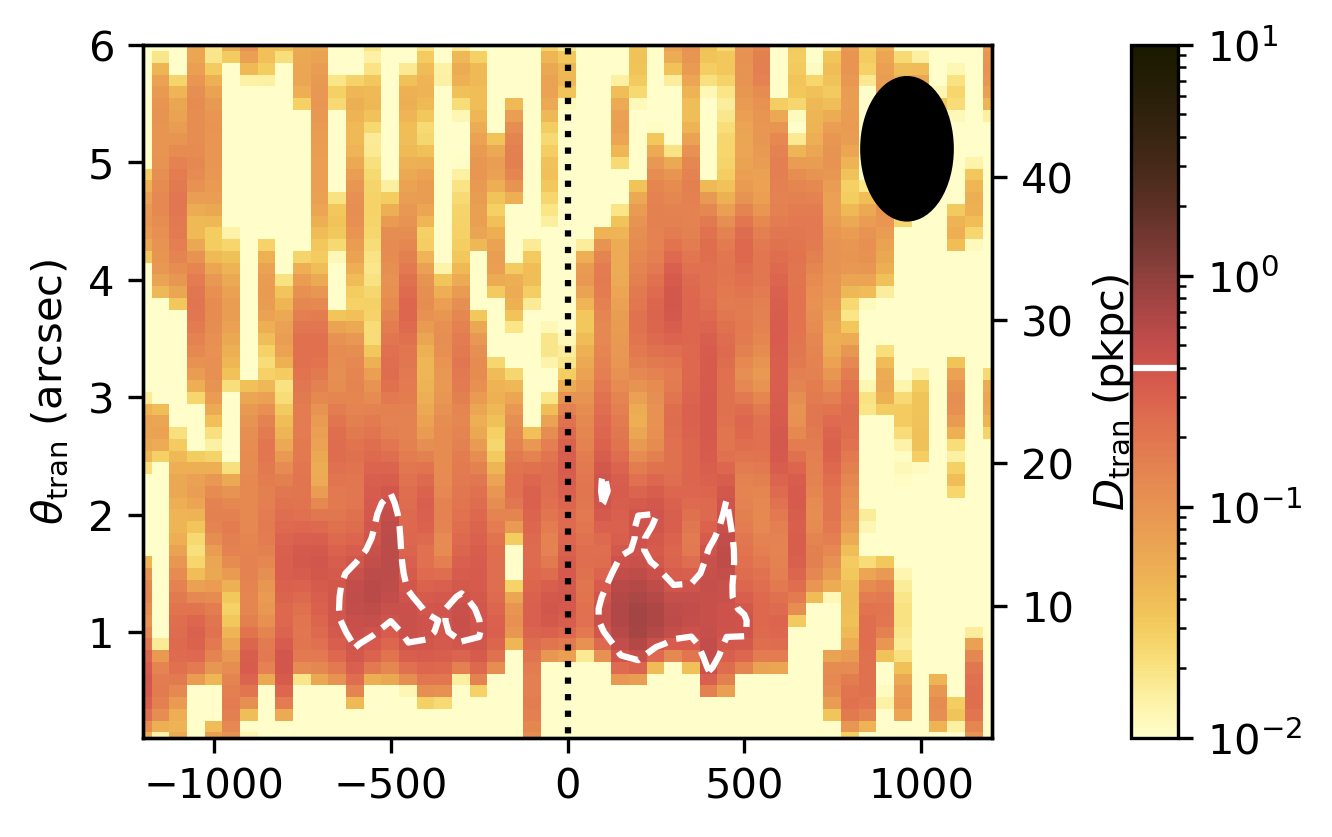

In [338]:
import common_tools
importlib.reload(common_tools)

fig, ax = plt.subplots(figsize=(5,3),dpi=300)

common_tools.plot_cp2d(result,fig,ax,log=True)
fig.savefig("/disk/bifrost/yuanze/KBSS/stack_analysis/fig/stack_ps_faintQSOs.pdf")

In [325]:
result.shape

(250, 53)

In [797]:
def stack_cp2d(tab, norm=None, med=False, return_cube=False, nsig=None, nboot=None, igmc=False, 
               get_vlyas=False, get_rprofile=False, cont=False, full=False, noism=False): 

    xnew = np.arange(-1300, 1350, 50)
    ynew = np.arange(0, 25., 0.1)
    xcorner = np.append(xnew, xnew[-1]+50) - 25
    ycorner = np.append(ynew, ynew[-1]+0.1) - 0.05
    xmesh, ymesh = np.meshgrid(xcorner, ycorner)
    xcmesh, ycmesh = np.meshgrid(xnew, ynew)
    
    xcont_new = np.arange(-20000, 20000, 100)
    ycont_new = np.arange(0, 10, 0.1)
    xcont_corner = np.append(xcont_new, xcont_new[-1] + 100) - 50
    ycont_corner = np.append(ycont_new, ycont_new[-1] + 0.1) - 0.05
    xcont_mesh, ycont_mesh = np.meshgrid(xcont_corner, ycont_corner)
    xccont_mesh, yccont_mesh = np.meshgrid(xcont_new, ycont_new)
    
    wcont_full = np.arange(1000, 1700, 0.5)
    xcont_full = (wcont_full - 1215.67) / 1215.67 * 3e5 + 1215.67
    ycont_full = np.arange(0, 10, 0.1)
    dxcont = xcont_full[1] - xcont_full[0]
    xcont_full_corner = np.append(xcont_full, xcont_full[-1] + dxcont) - dxcont / 2
    ycont_full_corner = np.append(ycont_full, ycont_full[-1] + 0.1) - 0.05
    xcont_full_mesh, ycont_full_mesh = np.meshgrid(xcont_full_corner, ycont_full_corner)
    xccont_full_mesh, yccont_full_mesh = np.meshgrid(xcont_full, ycont_full)
    
    if med:
        stackfunc = np.nanmedian
    else:
        stackfunc = np.nanmean
        
    if cont:
        xstack, ystack = xcont_new, ycont_new
        get_vlyas = False
        if full:
            xstack, ystack = xcont_full, ycont_full
            get_vlyas = False
    else:
        xstack, ystack = xnew, ynew
    
    stackcube = np.zeros((len(tab), len(ystack), len(xstack)))
    
    for i, element in enumerate(tab):
        #field = element['FILENAME'].split('-')[0]
        field=element['Field']
        objname=element['Name']
        #Type=element["Type"]
        #if Type!='QSO' and Type=='AGN/QSO':
        #    continue
        subdapath=KBSSpath+"/"+field+"/"+objname
        fn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(field.lower(),objname)
        #fn = '/Volumes/kbss-kcwi/tier3adv/' + field + '/twod/' + element['FILENAME']+'-'+element['OBJECT']+'_cp2d_lya_csub_mask.fits'
        
        if igmc:
            fn = fn.replace('.fits', '_igmc.fits')
            
        if cont:
            fn = '/Volumes/kbss-kcwi/tier3adv/' + field + '/twod/' + element['FILENAME'] + '-' + element['OBJECT'] + '_cp2d_full_mask.fits'

        if noism:
            fn = '/Volumes/kbss-kcwi/tier3adv/' +field +'/twod/noism/' + element['FILENAME'] + '-' + element['OBJECT'] + '_cp2d_lya_csub_noism_mask.fits'
                
        hdu = fits.open(fn)[0]
        hdr = hdu.header

        #wc = (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CD1_1'] + hdr['CRVAL1']
        wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
        vc = (wc / (1 + element['zlya']) - 1215.67) / 1215.67 *3e5
        dc = (np.arange(hdr['NAXIS2']) - hdr['CRPIX2'] + 1) * hdr['CD2_2'] + hdr['CRVAL2']
        
        # interpolation
        m2d=np.nansum(hdu.data,axis=2)
        print("interpolating with grid: ",vc.shape,dc.shape,"on",m2d.shape)
        interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
        cp2d_new = interpfunc(xstack, ystack)
        
        if norm is not None:
            cp2d_new = cp2d_new / norm[i]
        
        stackcube[i, :, :] = cp2d_new
        
    
    # safety 
    stackcube[stackcube == 0] = np.nan

    
    # sigma-clipping
    if nsig is not None:
        stackcube = astropy.stats.sigma_clip(stackcube, sigma=nsig, axis=0, masked=False)
        
    # stacked cp2d
    cp2d_stack = stackfunc(stackcube, axis=0)
        
    # bootstrap
    if nboot is not None:
        bootcube = np.zeros((nboot, len(ystack), len(xstack)))
        for i in range(nboot):
            rand = np.random.randint(0, len(tab)-1, size=len(tab))
            stackcube_rearrange = stackcube[rand, :, :]
            bootcube[i, :, :] = stackfunc(stackcube_rearrange, axis=0)
        
        booterr = np.nanstd(bootcube, axis=0)
        
    # vlyas
    if get_vlyas:
        vlyas0 = np.zeros((len(ynew), 16)) + np.nan
        # 16 params: v0, sigv, alpha, height, v0, sigv, alpha, height, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt
        if nboot is not None:
            vlyas_cube = np.zeros((nboot, len(ynew), 16)) + np.nan
        
        for i in tqdm(range(len(ynew))):
            if nboot is not None:
                fitmodel0, lyamodel0, ndim0, p0, psig0 = lya_bestmod(xnew, cp2d_stack[i, :], booterr[i, :])
            else:
                fitmodel0 = fit_lya_2
                lyamodel0 = lya_model
                p0, posig = fit_lya_2(xnew, cp2d_stack[i, :], np.ones_like(xnew), absolute_sigma=False, all_p=True)

            vlyas0[i, :8] = p0
            vlyas0[i, 8:] = calc_vlya(*p0)
            
            if nboot is not None:
                for j in range(nboot):
                    p0, _ = fitmodel0(xnew, bootcube[j, i, :], np.ones_like(xnew), all_p=True)
                    vlyas_cube[j, i, :8] = p0
                    vlyas_cube[j, i, 8:] = calc_vlya(*vlyas_cube[j, i, :8])

                # get error
                vlyas_cube[vlyas_cube == -9999] = np.nan
                vlyas_err = np.nanstd(vlyas_cube, axis=0)
                
    if get_rprofile:
        if cont:
            index_c = (xstack > 2000) & (xstack <= 5000)
            sb_c0 = np.sum(cp2d_stack[:, index_c], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

            if nboot is not None:
                sb_c_cube = np.zeros((nboot, len(ystack)))
                for j in range(nboot): 
                    sb_c_cube[j, :] = np.sum(bootcube[j, :, index_c], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

                sb_c_sig = np.std(sb_c_cube, axis=0)
        
        else:
            index_b = (xstack > -1000) & (xstack <= 0)
            index_r = (xstack > 0) & (xstack <= 1200)
            index_a = (xstack > -1000) & (xstack <= 1200)

            sb_b0 = np.sum(cp2d_stack[:, index_b], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
            sb_r0 = np.sum(cp2d_stack[:, index_r], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
            sb_a0 = np.sum(cp2d_stack[:, index_a], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

            if nboot is not None:
                sb_b_cube = np.zeros((nboot, len(ystack)))
                sb_r_cube = np.zeros((nboot, len(ystack)))
                sb_a_cube = np.zeros((nboot, len(ystack)))
                for j in range(nboot): 
                    sb_b_cube[j, :] = np.sum(bootcube[j, :, index_b], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
                    sb_r_cube[j, :] = np.sum(bootcube[j, :, index_r], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
                    sb_a_cube[j, :] = np.sum(bootcube[j, :, index_a], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

                sb_b_sig = np.std(sb_b_cube, axis=0)
                sb_r_sig = np.std(sb_r_cube, axis=0)
                sb_a_sig = np.std(sb_a_cube, axis=0)
        
        
    
    if (return_cube==False) and (nboot is None):
        result = cp2d_stack
    else:
        result = [cp2d_stack]
        
        if return_cube:
            result.append(stackcube)
        if nboot is not None:
            result.append(booterr)
            
        if get_vlyas:
            result.append(vlyas0)
            if nboot is not None:
                result.append(vlyas_err)
                
        if get_rprofile:
            if cont:
                result.append((sb_c0))
            else:
                result.append((sb_b0, sb_r0, sb_a0))
                
            if nboot is not None:
                if cont:
                    result.append((sb_c_sig))
                else:
                    result.append((sb_b_sig, sb_r_sig, sb_a_sig))
    return result

In [798]:
tab=QSOtab
xnew = np.arange(-1300, 1350, 50)
ynew = np.arange(0, 15., 0.1)
xcorner = np.append(xnew, xnew[-1]+50) - 25
ycorner = np.append(ynew, ynew[-1]+0.1) - 0.05
xmesh, ymesh = np.meshgrid(xcorner, ycorner)
xcmesh, ycmesh = np.meshgrid(xnew, ynew)

xcont_new = np.arange(-20000, 20000, 100)
ycont_new = np.arange(0, 10, 0.1)
xcont_corner = np.append(xcont_new, xcont_new[-1] + 100) - 50
ycont_corner = np.append(ycont_new, ycont_new[-1] + 0.1) - 0.05
xcont_mesh, ycont_mesh = np.meshgrid(xcont_corner, ycont_corner)
xccont_mesh, yccont_mesh = np.meshgrid(xcont_new, ycont_new)

wcont_full = np.arange(1000, 1700, 0.5)
xcont_full = (wcont_full - 1215.67) / 1215.67 * 3e5 + 1215.67
ycont_full = np.arange(0, 10, 0.1)
dxcont = xcont_full[1] - xcont_full[0]
xcont_full_corner = np.append(xcont_full, xcont_full[-1] + dxcont) - dxcont / 2
ycont_full_corner = np.append(ycont_full, ycont_full[-1] + 0.1) - 0.05
xcont_full_mesh, ycont_full_mesh = np.meshgrid(xcont_full_corner, ycont_full_corner)
xccont_full_mesh, yccont_full_mesh = np.meshgrid(xcont_full, ycont_full)

stackfunc = np.nanmean

xstack, ystack = xnew, ynew

stackcube = np.zeros((len(tab), len(ystack), len(xstack)))

for i, element in enumerate(tab):
    #field = element['FILENAME'].split('-')[0]
    field=element['Field']
    objname=element['Name']
    #Type=element["Type"]
    #if Type!='QSO' and Type=='AGN/QSO':
    #    continue
    subdapath=KBSSpath+"/"+field+"/"+objname
    fn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(field.lower(),objname)
    #fn = '/Volumes/kbss-kcwi/tier3adv/' + field + '/twod/' + element['FILENAME']+'-'+element['OBJECT']+'_cp2d_lya_csub_mask.fits'
                
    hdu = fits.open(fn)[0]
    hdr = hdu.header

    #wc = (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CD1_1'] + hdr['CRVAL1']
    wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
    vc = (wc / (1 + element['zlya']) - 1215.67) / 1215.67 *3e5
    dc = (np.arange(hdr['NAXIS2']) - hdr['CRPIX2'] + 1) * hdr['CD2_2'] + hdr['CRVAL2']
    
    # interpolation
    m2d=np.nansum(hdu.data,axis=2)
    print("interpolating with grid: ",vc.shape,dc.shape,"on",m2d.shape)
    interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
    cp2d_new = interpfunc(xstack, ystack)
    
    stackcube[i, :, :] = cp2d_new


FileNotFoundError: [Errno 2] No such file or directory: '/disk/bifrost/yuanze/KBSS/Q0100/Q0100+13/kcwi_oned/q0100-Q0100+13_icubes_wcs.cyli.fits'

In [155]:
np.max(hdu.data)

0.0

In [156]:
fn

'/disk/bifrost/yuanze/KBSS/Q2343/Q2343/kcwi_oned/q2343-Q2343_icubes_wcs.cyli.fits'

# 3. reproject PSF subtracted cube onto cylindrical system: Hyperluminous QSOs

## Read data and do the stacking

In [48]:
sys.path.append('/disk/bifrost/yuanze/KBSS/MUSEQSO/scripts')
import run_cubetools_MUSE as ctools
root_directory = KBSSpath+"/MUSEQSO"
source_table = ascii.read(root_directory+"/MUSEQSO_machine_readable_updated2_withMi2.list",format="ipac")#QSOtab=qsos[(qsos['contam']=="False")&(qsos['Field']!="Q1623")]
filters = ["table['file_count'] < 2","table['M_i_z2']<-29.2","table['z_sys']<3.5"]
#QSOtab=qsos[(qsos['Field']!="Q0142")&(qsos['Field']!="Q1623")]
all_directories,tab = ctools.find_directories_from_ascii(source_table,root_directory,filters=filters)

In [49]:
tab[tab["Quasar"]=="SDSSJ0125-1027"]

ID,Quasar,RA,Decl,Seeing,z_sys,z_Lyaneb,EXPT,L_Lya,M_BH,L_bol,Class,found_in_folder,file_count,i_AB,M_i,M_i_z2,cutout,withabs
unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,,,,,,,
str2,str15,str12,str12,float64,float64,float64,float64,float64,float64,float64,str2,str4,int64,float64,float64,float64,str5,str5


In [51]:
tab

ID,Quasar,RA,Decl,Seeing,z_sys,z_Lyaneb,EXPT,L_Lya,M_BH,L_bol,Class,found_in_folder,file_count,i_AB,M_i,M_i_z2,cutout,withabs
unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,,,,,,,
str2,str15,str12,str12,float64,float64,float64,float64,float64,float64,float64,str2,str4,int64,float64,float64,float64,str5,str5
2,UM24,00:15:27.400,+06:40:12.00,1.62,3.133,3.165,42.29,2.82,6.05,3.77,RQ,True,1,17.08,-30.109136031614547,-29.733236031614545,False,False
6,SDSSJ0947+1421,09:47:34.200,+14:21:17.00,1.21,3.029,3.069,42.27,0.64,7.96,3.46,RQ,True,1,17.04,-30.06126860800186,-29.71266860800186,False,False
9,Q 0956+122,09:58:52.200,+12:02:45.00,1.12,3.301,3.311,42.25,9.33,3.64,3.22,RQ,True,1,17.48,-29.84482392241976,-29.44692392241976,False,False
19,SDSSJ1307+1230,13:07:10.200,+12:30:21.00,0.89,3.188,3.225,42.25,1.84,6.27,2.34,RQ,True,1,17.58,-29.654379101339202,-29.261979101339204,False,False
26,Q-2204-408,22:07:34.300,-40:36:57.00,0.84,3.181,3.185,42.35,11.16,10.11,3.72,-,True,1,17.17,-30.058666436570633,-29.668366436570633,False,False
46,Q2355+0108,23:58:08.540,+01:25:07.20,1.23,3.385,3.398,42.19,1.91,3.93,2.52,RQ,True,1,17.61,-29.77998207499723,-29.37898207499723,False,False
62,CTS_G18.01,00:41:31.4,-49:36:11.9,1.08,3.207,3.249,48.32,3.78,5.41,3.95,RQ,True,1,16.621,-30.62881899665722,-30.23141899665722,False,False
71,CT_656,06:00:08.07,-50:40:36.8,0.7,3.159,3.154,54.37,1.01,3.84,1.93,RQ,True,1,17.549,-29.633486077407483,-29.259986077407483,False,False


In [5]:
#reload(kcwi_tools)
#Deprecated: I have a MPI version in /MUSEQSO/scripts
import gc
#radius=6
overwrite=True
for subdir in all_directories:
    adp_prefix = ctools.find_adp_fits_file(subdir)
    quasar_name = os.path.basename(subdir)
    #overwrite=True
    sentry = source_table[source_table['Quasar'] == quasar_name]
    Subfile = adp_prefix+".PSFCONTSub.fits"
    psfcen = np.loadtxt(subdir+"/psfcen.txt")
    xpix = psfcen[0,1]
    ypix = psfcen[0,2]
    writefn=adp_prefix+".PSFCONTSub.cyli.fits"
    if False:#sentry["contam"]=="True":
        overwrite=True
        maskfn=subdapath+"/{}.reg".format(field)
    else:
        maskfn=''
    if overwrite == True or (not os.path.exists(writefn)):
        print("reprojecting",subdir.split("/")[-1],"to cylindrical system...")
        print("writing:",writefn)
        hdu=fits.open(Subfile)
        #hdu2=fits.open(cubefile)
        hdu[0].header["CNAME3"]="Wavelength"
        nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],hdr=hdu[0].header,cos=Planck18,r_range=[0,15],maskfn=maskfn,writefn=writefn,montage=True)
        hdu.close()
        del nhdu
        gc.collect()
    else:
        print(f"reprojected cube existed for {quasar_name:s}: no stacking performed ")


reprojecting SDSSJ2319-1040 to cylindrical system...
writing: /disk/bifrost/yuanze/KBSS/MUSEQSO/SDSSJ2319-1040/ADP.2016-06-21T08:30:08.244.PSFCONTSub.cyli.fits
updating hdr


KeyboardInterrupt: 

## Reprojection completed! Do the stacking.

#### Grid setup

In [46]:
xnew = np.arange(-4000, 3000, 50)
ynew = np.arange(1.0, 8.7, 0.3)
xcorner = np.append(xnew, xnew[-1]+50) - 25
ycorner = np.append(ynew, ynew[-1]+0.1) - 0.05
xmesh, ymesh = np.meshgrid(xcorner, ycorner)
xcmesh, ycmesh = np.meshgrid(xnew, ynew)

xcont_new = np.arange(-20000, 20000, 100)
ycont_new = np.arange(0, 10, 0.1)
xcont_corner = np.append(xcont_new, xcont_new[-1] + 100) - 50
ycont_corner = np.append(ycont_new, ycont_new[-1] + 0.1) - 0.05
xcont_mesh, ycont_mesh = np.meshgrid(xcont_corner, ycont_corner)
xccont_mesh, yccont_mesh = np.meshgrid(xcont_new, ycont_new)

wcont_full = np.arange(1000, 1700, 0.5)
xcont_full = (wcont_full - 1215.67) / 1215.67 * 3e5 + 1215.67
ycont_full = np.arange(0, 10, 0.1)
dxcont = xcont_full[1] - xcont_full[0]
xcont_full_corner = np.append(xcont_full, xcont_full[-1] + dxcont) - dxcont / 2
ycont_full_corner = np.append(ycont_full, ycont_full[-1] + 0.1) - 0.05
xcont_full_mesh, ycont_full_mesh = np.meshgrid(xcont_full_corner, ycont_full_corner)
xccont_full_mesh, yccont_full_mesh = np.meshgrid(xcont_full, ycont_full)

## Test

In [62]:
importlib.reload(ctools)
filters = [ "table['file_count'] < 2","table['z_sys'] < 3.5","table['M_i']<-29.6"]
#filters = ["table['file_count'] < 2","table['M_i']>-29.6"]

#QSOtab=qsos[(qsos['Field']!="Q0142")&(qsos['Field']!="Q1623")]
all_directories,tab = ctools.find_directories_from_ascii(source_table,root_directory,filters=filters)

In [39]:
from astropy.io import fits
hdu0=fits.open("/disk/bifrost/yuanze/KBSS/MUSEQSO/UM24/ADP.2016-06-21T08:30:08.213.PSFSub.fits")
hdu1=fits.open("/disk/bifrost/yuanze/KBSS/MUSEQSO/UM24/ADP.2016-06-21T08:30:08.213.PSFCONTSub.fits")

In [51]:
import glob
from mpdaf.obj import CubeList,CubeMosaic
cubes = glob.glob(all_directories[0]+"/ADP*")
l = CubeList(cubes)


[WARNING] all cubes have not same dimensions
[WARNING] 3681 X 314 X 317 cube (/disk/bifrost/yuanze/KBSS/MUSEQSO/Q-0347-383/ADP.2016-06-02T12:48:48.991.fits)
[WARNING] 3681 X 314 X 319 cube (/disk/bifrost/yuanze/KBSS/MUSEQSO/Q-0347-383/ADP.2016-06-02T13:21:57.103.fits)
[WARNING] all cubes have not same spatial coordinates
[INFO] /disk/bifrost/yuanze/KBSS/MUSEQSO/Q-0347-383/ADP.2016-06-02T12:48:48.991.fits
[INFO] center:(-38:10:30.98524153,03:49:43.69928871) size:(62.800",63.400") step:(0.200",0.200") rot:-0.0 deg frame:FK5
[INFO] /disk/bifrost/yuanze/KBSS/MUSEQSO/Q-0347-383/ADP.2016-06-02T13:21:57.103.fits
[INFO] center:(-38:10:30.94406901,03:49:43.68415856) size:(62.800",63.800") step:(0.200",0.200") rot:-0.0 deg frame:FK5


In [10]:
tab

ID,Quasar,RA,Decl,Seeing,z_sys,z_Lyaneb,EXPT,L_Lya,M_BH,L_bol,Class,found_in_folder,file_count,i_AB,M_i,M_i_z2,cutout
unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,,,,,,
str2,str15,str12,str12,float64,float64,float64,float64,float64,float64,float64,str2,str4,int64,float64,float64,float64,str5
1,SDSSJ2319-1040,23:19:34.800,-10:40:36.00,1.4,3.166,3.171,42.44,1.53,0.87,1.27,RQ,True,1,18.17,-29.046380597576686,-28.659580597576685,False
3,J0525-233,05:25:06.500,-23:38:10.00,0.86,3.11,3.119,42.88,1.29,1.86,2.18,RL,True,1,17.71,-29.45996927963563,-29.09096927963563,False
5,SDSSJ0817+1053,08:17:52.099,+10:53:29.68,1.47,3.32,3.332,42.44,3.18,3.25,1.87,RQ,True,1,18.08,-29.259712756974267,-28.864712756974267,False
7,SDSSJ1209+1138,12:09:18.000,+11:38:31.00,1.22,3.117,3.118,42.23,1.89,2.15,2.45,RQ,True,1,17.63,-29.545818292114614,-29.174718292114616,False
8,UM683,03:36:26.900,-20:19:39.00,1.05,3.132,3.132,85.02,4.45,0.44,1.27,RQ,True,1,18.59,-28.598305759306687,-28.222705759306688,False
10,SDSSJ10251+0452,10:25:09.600,+04:52:46.00,1.1,3.227,3.242,42.58,7.7,2.17,2.15,RQ,True,1,17.92,-29.34596846060454,-28.94456846060454,False
11,Q-N1097.1,02:46:34.200,-30:04:55.00,1.18,3.078,3.099,42.47,1.71,1.28,0.78,RQ,True,1,18.81,-28.33305440893619,-27.97145440893619,False
12,SDSSJ1019+0254,10:19:08.255,+02:54:31.94,1.22,3.376,3.394,42.1,4.03,4.09,2.18,RQ,True,1,18.26,-29.12308226945036,-28.72568226945036,False


## Start Stacking

In [47]:
importlib.reload(kcwi_tools)
importlib.reload(common_tools_yd)
result=common_tools_yd.stack_cp2d_MUSE(all_directories,source_table,get_rprofile=False,return_cube=True,nboot=80,get_vlyas=True,stackgrid=(xnew,ynew))
#result_var=common_tools_yd.stack_cp2d_MUSE(all_directories,source_table,get_rprofile=True,return_cube=True,nboot=40,get_vlyas=False,stackgrid=(xnew,ynew),variance=True)

#result_QSO=common_tools_yd.stack_cp2d_MUSE(all_directories,source_table,get_rprofile=True,return_cube=True,nboot=80,get_vlyas=False,stackgrid=(xnew,ynew),QSO=True)

interpolating with grid:  (3681,) (50,) on (3681, 50)
interpolating with grid:  (3681,) (50,) on (3681, 50)
interpolating with grid:  (3681,) (50,) on (3681, 50)
interpolating with grid:  (3802,) (50,) on (3802, 50)
interpolating with grid:  (3682,) (50,) on (3682, 50)


/disk/bifrost/yuanze/software/KcwiKit/py/common_tools_yd.py:996: RuntimeWarning: Mean of empty slice
  m2d=np.nanmean(hdu.data,axis=2)


interpolating with grid:  (3682,) (50,) on (3682, 50)
interpolating with grid:  (3681,) (50,) on (3681, 50)
interpolating with grid:  (3682,) (50,) on (3682, 50)
interpolating with grid:  (3682,) (50,) on (3682, 50)
interpolating with grid:  (3681,) (50,) on (3681, 50)
interpolating with grid:  (3681,) (50,) on (3681, 50)
interpolating with grid:  (3682,) (50,) on (3682, 50)
interpolating with grid:  (3802,) (50,) on (3802, 50)
interpolating with grid:  (3682,) (50,) on (3682, 50)
interpolating with grid:  (3682,) (50,) on (3682, 50)
interpolating with grid:  (3682,) (50,) on (3682, 50)
interpolating with grid:  (3682,) (50,) on (3682, 50)
interpolating with grid:  (3681,) (50,) on (3681, 50)
interpolating with grid:  (3681,) (50,) on (3681, 50)
interpolating with grid:  (3681,) (50,) on (3681, 50)
interpolating with grid:  (3682,) (50,) on (3682, 50)
interpolating with grid:  (3681,) (50,) on (3681, 50)
interpolating with grid:  (3681,) (50,) on (3681, 50)
interpolating with grid:  (3

  0%|          | 0/26 [00:00<?, ?it/s]/disk/bifrost/yuanze/anaconda3/envs/kcwidrp/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
100%|██████████| 26/26 [04:34<00:00, 10.56s/it]


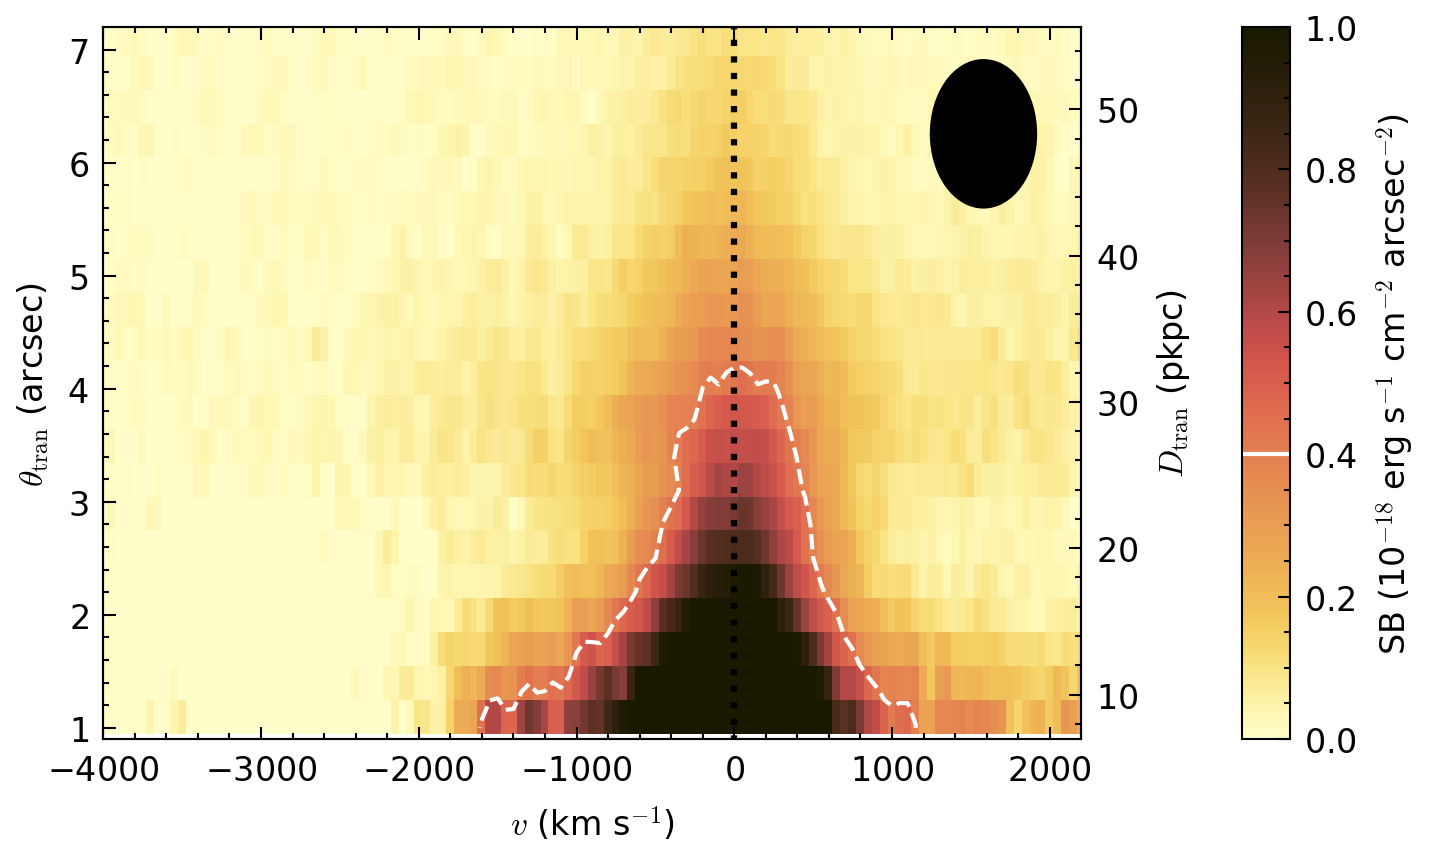

In [44]:
#import common_tools
#importlib.reload(common_tools)
import scienceplots
importlib.reload(common_tools_yd)
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

fig, ax = plt.subplots(figsize=(5,3),dpi=300)

common_tools_yd.plot_cp2d(result[0]*1e-2/0.04,fig,ax,log=False,PSFSub=True,HL=True,cosmo=Planck18,redshift=3.2,stackgrid=(xnew,ynew))
fig.tight_layout()

#fig.savefig(root_directory+"/QSOs_r6/stack_ps_HLQSOs.pdf")

In [114]:
S2011=np.genfromtxt(KBSSpath+"/Steidel2011.csv",delimiter=",")
B2016=np.genfromtxt(KBSSpath+"/Borisova2016.csv",delimiter=",")
F2019=np.genfromtxt(KBSSpath+"/FAB2019.csv",delimiter=",")


Text(0, 0.5, '$(1+z/4)^{4}$ SB $\\rm (10^{-18} erg~s^{-1}~cm^{-2}~arcsec^{-2})$')

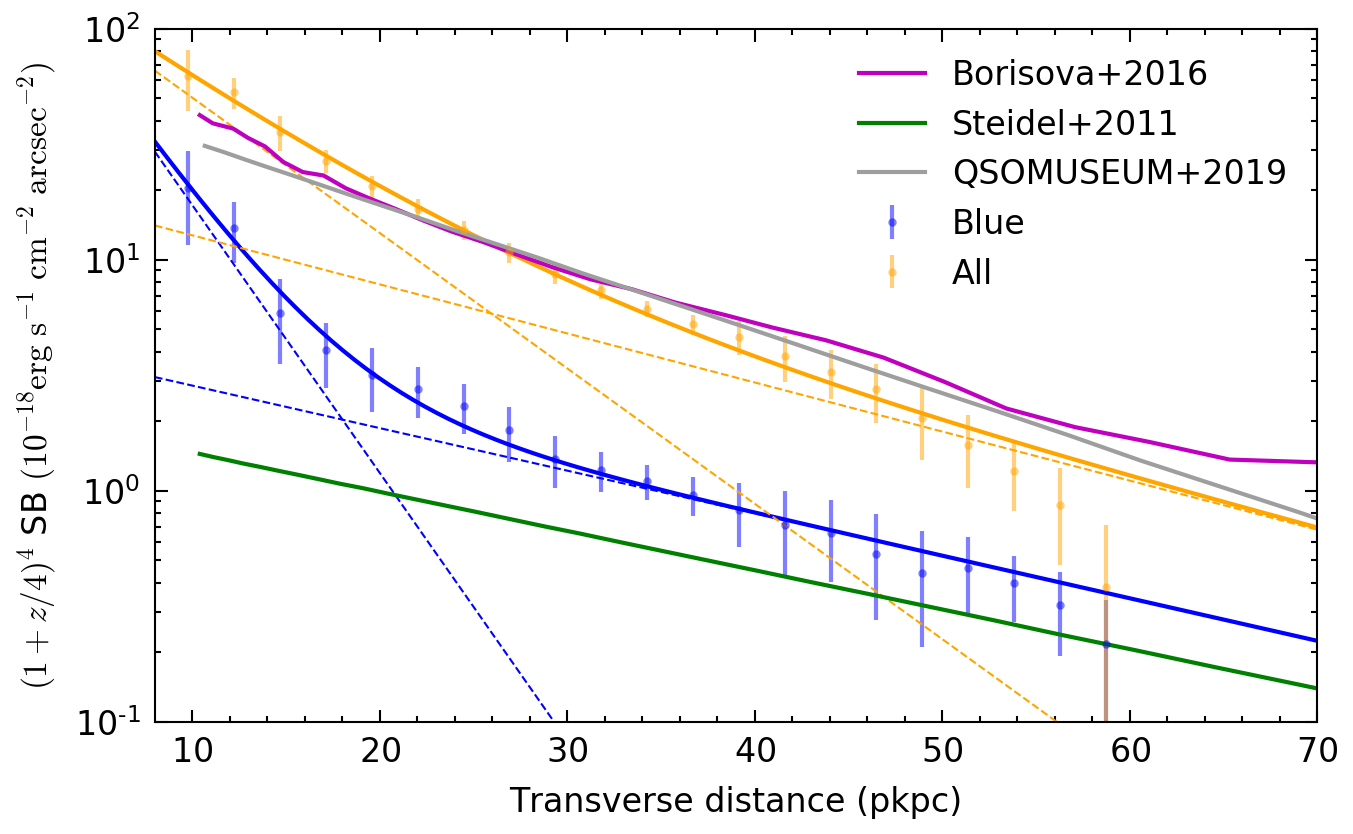

In [147]:
from astropy.modeling import Fittable1DModel, Parameter
import emcee
from scipy.optimize import curve_fit
from scipy import signal
from importlib import reload
reload(common_tools_yd)
from common_tools_yd import spatial_profile_2exp
class OffsetExponential1D(Fittable1DModel):
    amplitude = Parameter()
    tau = Parameter()
    offset = Parameter()
    x_offset = Parameter()

    @staticmethod
    def evaluate(x, amplitude, tau, offset, x_offset):
        return amplitude * np.exp(-(x - x_offset) / tau) + offset

    @staticmethod
    def fit_deriv(x, amplitude, tau, offset, x_offset):
        exp_term = np.exp(-(x - x_offset) / tau)
        d_amplitude = exp_term
        d_tau = amplitude * (x - x_offset) * exp_term / tau**2
        d_offset = np.ones_like(x)
        d_x_offset = amplitude * exp_term / tau
        return [d_amplitude, d_tau, d_offset, d_x_offset]
'''
def log_likelihood(theta, x, y, yerr, model):
    model.parameters = theta
    y_model = model(x)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - y_model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    amp_exp, tau_exp, offset_exp, x_offset_exp, amp_pow, x0_pow, alpha_pow, amp_exp2, tau_exp2 = theta
    if (0 < amp_exp < 100 and 0 < tau_exp < 50 and -10 < offset_exp < 10 and 0 < x_offset_exp < 50 and
        0 < amp_pow < 100 and 0 < x0_pow < 50 and -5 < alpha_pow < 5 and 0 < amp_exp2 < 100 and -50 < tau_exp2 < 0):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr, model):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, model)
'''
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

fig, ax = plt.subplots(figsize=(5,3),dpi=300)

initial_guess = [1, 10, 1, 30]  # Initial guess for the parameters
fitfunc=spatial_profile_2exp

kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60
cut1=1
cut2=22
scolor=["Blue","Red","All"]
colorl=["b","r","orange"]
sresult={}
for side in [0,2]:
    x_data=ynew[cut1:cut2]*kpc_per_arcsec
    y_data=result[5][side][cut1:cut2]*100*((1+2.65)/4)**4
    y_err=result[6][side][cut1:cut2]*100*((1+2.65)/4)**4
    ax.errorbar(x_data,y_data,yerr=y_err
                ,fmt="o",
            label=scolor[side],
            color=colorl[side],
                mfc="none",
                ms=1.,
            capsize=0.0,
            ls="None",
                alpha=0.5,
            lw=1)
    #model=models.Moffat1D(amplitude=1e-17,x_0=0)
    #model.x_0.fixed=True
    # Fit the model
    fcut=21
    params, covariance = curve_fit(fitfunc, x_data[:fcut], y_data[:fcut], p0=initial_guess)
    sresult[scolor[side]]=params
    #fitted_model = fitter(model,x_data[:fcut],y_data[:fcut],weights=1/y_err[:fcut]**2)
    x_fit = np.linspace(8,70, 100)
    #y_fit=fitted_model(x_fit)
    y_fit=fitfunc(x_fit, *params)
    
    y_fit_comp1=fitfunc(x_fit,params[0],params[1],0,1)
    y_fit_comp2=fitfunc(x_fit,0,1,params[2],params[3])
    ax.plot(x_fit,y_fit,color=colorl[side])
    #if side==0:
    ax.plot(x_fit,y_fit_comp1,ls="--",color=colorl[side],lw=0.5)
    ax.plot(x_fit,y_fit_comp2,ls="--",color=colorl[side],lw=0.5)

ax.plot(B2016[:,0],B2016[:,1]*1e18,color="m",label="Borisova+2016")
ax.plot(S2011[:,0],S2011[:,1]*1e18,color="g",label="Steidel+2011")
ax.plot(F2019[:,0],F2019[:,1]*1e18*((1+3.15)/4)**4,color="C6",label="QSOMUSEUM+2019")

#ax.plot(x_fit,fitted_model[1](x_fit),"r")
#ax.axvline(kpc_per_arcsec*0.3*15,ls="--",lw=0.5)
#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([8,70])
ax.set_ylim([0.1,100])
ax.set_yscale("log")
#ax.set_xscale("log")
ax.legend()
ax.set_xlabel("Transverse distance (pkpc)")
#ax.set_xlabel("Transverse distance (arcsec)")

ax.set_ylabel(r"$(1+z/4)^{4}$ SB $\rm (10^{-18} erg~s^{-1}~cm^{-2}~arcsec^{-2})$")

#fig.savefig(KBSSpath+"/QSOs_r{}_newcode/SB_profile.pdf".format(radius))
# try rmax at 6 arcsec?

In [111]:
print(sresult)
print(kpc_per_arcsec)

{'Blue': array([284.77613945,   0.40369835,   7.58527686,   2.55292203]), 'Red': array([62.96772423,  1.47782975, 62.97082037,  1.47779806]), 'All': array([210.02845475,   0.84011446,  50.78401995,   2.11303369])}
8.154436770555874


In [ ]:
Luv=2.44e-4

In [910]:
sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 5000/5000 [00:29<00:00, 167.03it/s]


State([[60.45029813 19.83016194 -7.05239713 19.48405549 42.5641912   8.70701191
  -4.26984979 83.16412684 -2.25946659]
 [92.51855785 15.83876409 -3.67083219 12.52478654 45.47528703 45.87626479
  -1.06603639 18.71659208 -6.40995663]
 [58.25111324 21.86775873 -9.67150377 20.25781706 34.45934619  7.40916815
  -4.52486402 66.73243581 -2.149657  ]
 [97.17328615 23.03587861 -9.45581059  7.21429206 54.56201669  6.87776553
  -3.4353139  23.06421259 -2.63287018]
 [75.19075015 22.91902158 -8.42737894 11.21536838 97.73090488 44.23614162
  -1.40047489 68.9905179  -4.53146485]
 [70.37153368 19.64127955 -7.89260772 17.82673447 95.97178926  6.52180229
  -3.86462788 37.51411652 -1.96643117]
 [80.45904072 22.6532786  -9.8665877  13.10162771 63.69372752  5.81970649
  -4.32932389 21.22435831 -2.07898295]
 [43.34147551 14.48764062 -3.90844288 26.67144134 20.89692004 43.05206441
  -3.32585589 40.37597026 -0.611344  ]
 [45.48009868 22.13225473 -8.08182533 23.76457897 49.47895479 13.70602829
  -2.0627833  73

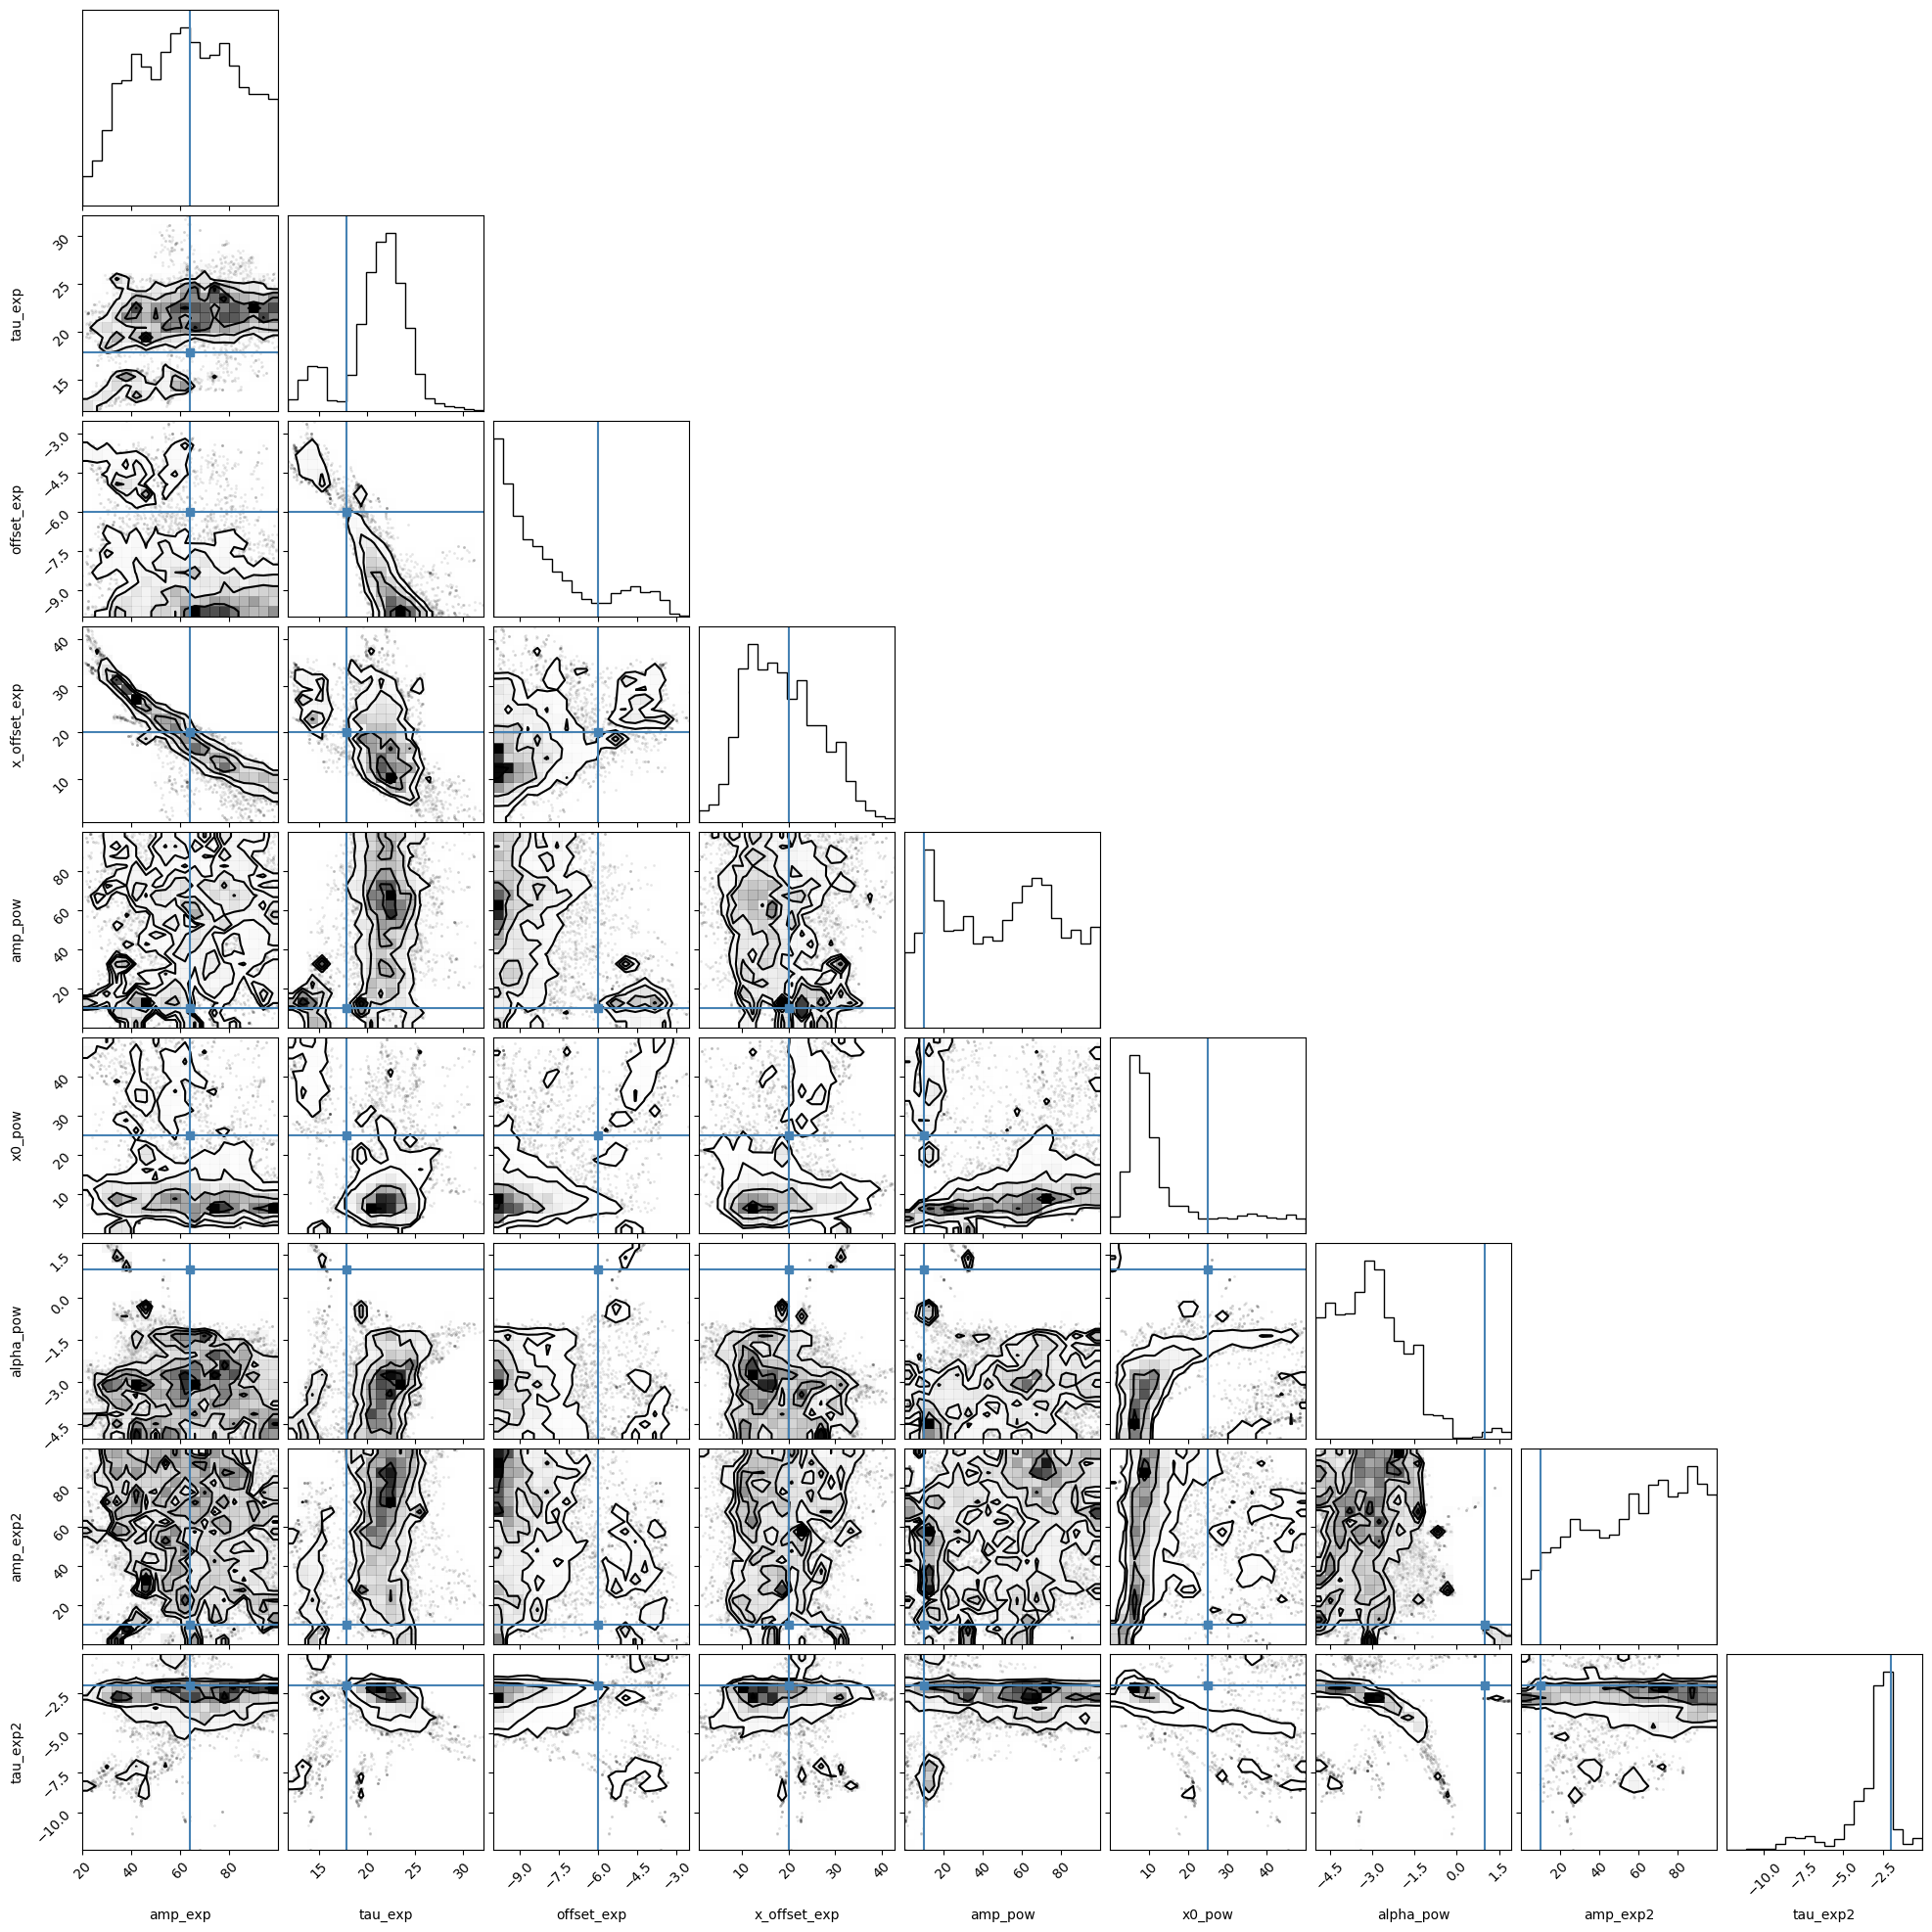

Parameter 1: 62.637 +22.799 -22.492
Parameter 2: 21.553 +2.289 -3.016
Parameter 3: -8.645 +3.144 -1.054
Parameter 4: 17.887 +9.562 -7.119
Parameter 5: 52.905 +28.066 -37.780
Parameter 6: 9.764 +20.350 -3.948
Parameter 7: -3.083 +1.370 -1.267
Parameter 8: 59.437 +28.229 -35.945
Parameter 9: -2.745 +0.684 -1.572


In [911]:
import corner

# Discard burn-in samples and flatten the chain
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Plot the corner plot
fig = corner.corner(flat_samples, labels=["amp_exp", "tau_exp", "offset_exp", "x_offset_exp",
                                          "amp_pow", "x0_pow", "alpha_pow", "amp_exp2", "tau_exp2"],
                    truths=initial)
plt.show()

# Calculate the statistics for the parameters
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"Parameter {i+1}: {mcmc[1]:.3f} +{q[1]:.3f} -{q[0]:.3f}")

In [37]:
#16 params: v0, sigv, alpha, height, v0, sigv, alpha, height, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt
vgrid = np.arange(-3000, 3001, 1)

1.0 corresponds to 0.9
1.3 corresponds to 1.2
1.6 corresponds to 1.5
1.9000000000000001 corresponds to 1.8
2.2 corresponds to 2.1
2.2 corresponds to 2.1
1/igmfac= 0.5289371660469671
2.5 corresponds to 2.4
2.5 corresponds to 2.4
1/igmfac= 0.5613461290576531
2.8000000000000003 corresponds to 2.7
2.8000000000000003 corresponds to 2.7
1/igmfac= 0.4887800497582377
3.1000000000000005 corresponds to 2.9
3.1000000000000005 corresponds to 2.9
1/igmfac= 0.48086828337283793
3.4000000000000004 corresponds to 3.2
3.7 corresponds to 3.5
4.0 corresponds to 3.8
4.0 corresponds to 3.8
1/igmfac= 0.3502322986247993
4.300000000000001 corresponds to 4.1
4.300000000000001 corresponds to 4.1
1/igmfac= 0.34101644792534863
4.6000000000000005 corresponds to 4.4
4.9 corresponds to 4.6
4.9 corresponds to 4.6
1/igmfac= 0.3120815536948118
5.200000000000001 corresponds to 4.9
5.200000000000001 corresponds to 4.9
1/igmfac= 0.3014342564599348
5.500000000000001 corresponds to 5.2
5.500000000000001 corresponds to 5.2
1/

IndexError: index 22 is out of bounds for axis 0 with size 22

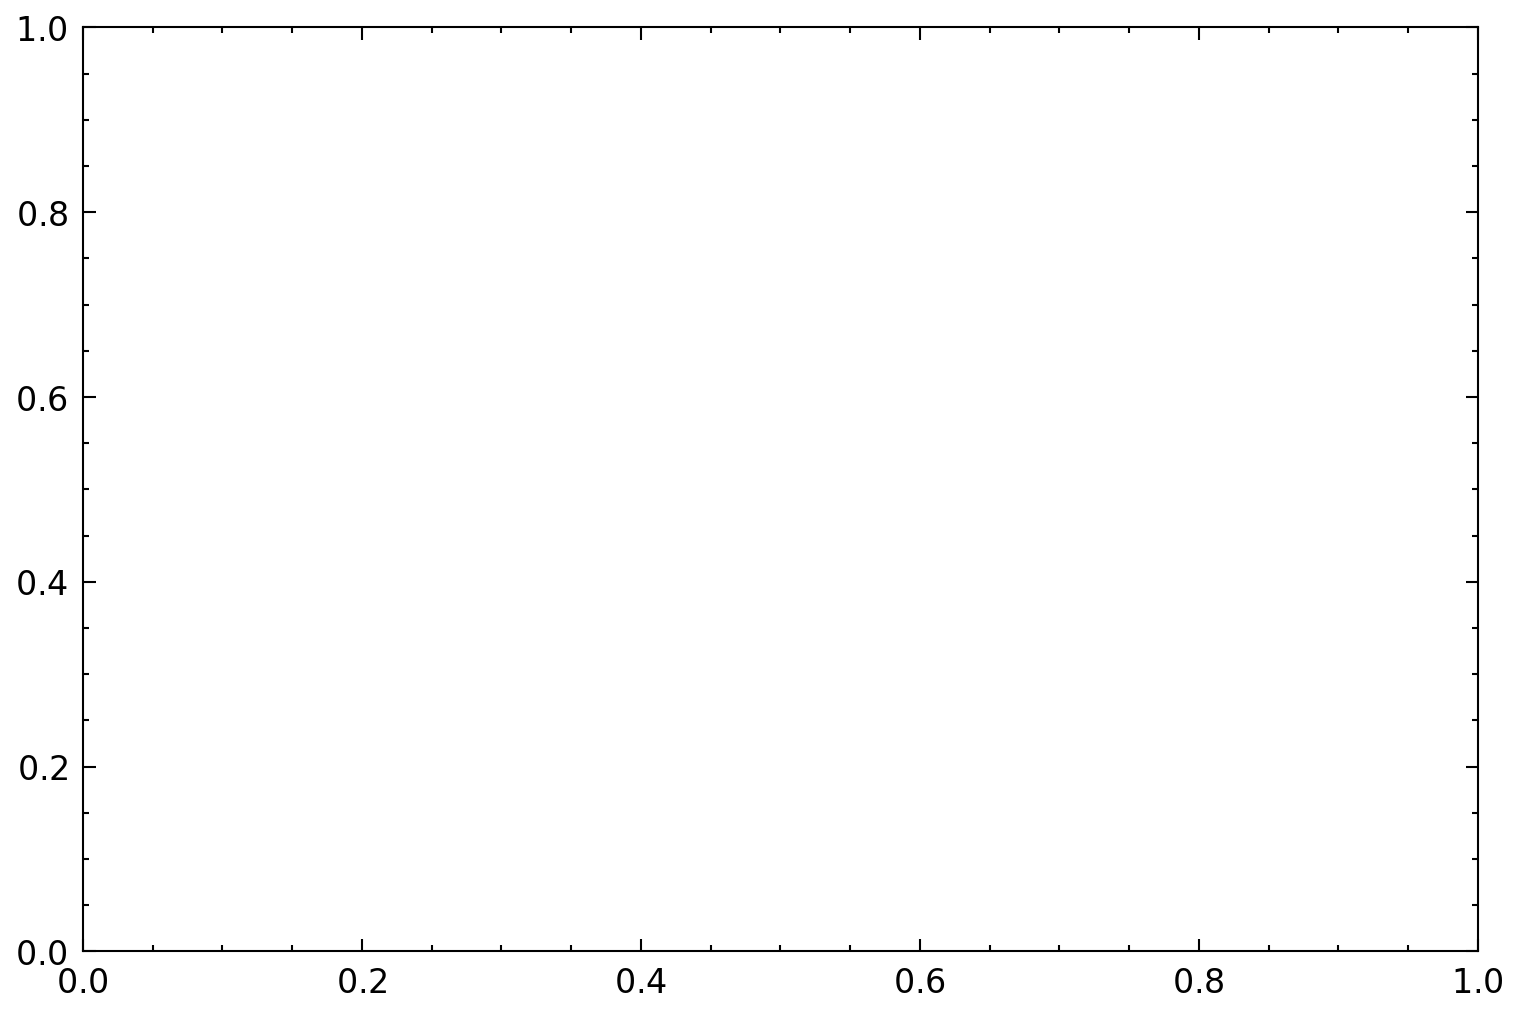

In [45]:
###### for xind in range(31):
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})


#this_z=3.22
this_z=3.2
efactor=1#1e-2/0.04*((1+this_z)/3.658)**3
kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(this_z).value/60
kpc_per_arcsec_lowz=Planck18.kpc_proper_per_arcmin(2.658).value/60

plotKBSS=True

cind=0
#cmean,cmedian,_   =sigma_clipped_stats(result_QSO[0][cind,:],maxiters=None)
#cmax=np.max(result_QSO[0][cind,:]-cmedian)

for xind in range(66):
    
    fig, ax = plt.subplots(figsize=(6,4),dpi=300)
    p00, p01, p02, p03, p10, p11, p12, p13, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt=result[3][xind,:]
    p00err, p01err, p02err, p03err, p10err, p11err, p12err, p13err, p0err, vp0err, fwhm0err, p1err, vp1err, fwhm1err, trougherr, vterr=result[4][xind,:]
    if p13<0:
        mod = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
        string=f"FWHM = {fwhm1:.1f}$\pm${fwhm1err:.1f}; Velocity = {vp1:.1f}$\pm${vp1err:.1f}; skewness = {p02:.1f}$\pm${p02err:.1f}"
    elif p12 <=0:
        mod = common_tools_yd.lya_model_3(vgrid, p00, p01, p03, p10, p11, p13)
        mod1 = common_tools_yd.sym_gauss(vgrid, p00, p01, p03)
        mod2 = common_tools_yd.sym_gauss(vgrid, p10, p11, p13)
        #ax.plot(vgrid,mod1*efactor,"C2",label="Component 1",lw=1.0)
        #ax.plot(vgrid,mod2*efactor,"C3",label="Component 2",lw=1.0)
        string=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.1f}, {fwhm1:.0f}$\pm${fwhm1err:.1f}; Velocity = {vp0:.1f}$\pm${vp0err:.1f}, {vp1:.1f}$\pm${vp1err:.1f};"+"\n"\
        +f"Peak = {p0*efactor:.1f}$\pm${p0err*efactor:.1f}, {p1*efactor:.1f}$\pm${p1err*efactor:.1f}"
    elif p02 <=0:
        mod = common_tools_yd.lya_model_2p(vgrid, p00, p01, p03, p10, p11, p12, p13)
        mod1 = common_tools_yd.sym_gauss(vgrid, p00, p01, p03)
        mod2 = common_tools_yd.skew_gauss(vgrid, p10, p11,p12, p13)
        #ax.plot(vgrid,mod1*efactor,"C2",label="Component 1",lw=1.0)
        #ax.plot(vgrid,mod2*efactor,"C3",label="Component 2",lw=1.0)
        string=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.1f}, {fwhm1:.0f}$\pm${fwhm1err:.1f}; Velocity = {vp0:.1f}$\pm${vp0err:.1f}, {vp1:.1f}$\pm${vp1err:.1f};"+"\n"\
        +f"skewness = {p12:.1f}$\pm${p12err:.1f}; Peak = {p0*efactor:.1f}$\pm${p0err*efactor:.1f}, {p1*efactor:.1f}$\pm${p1err*efactor:.1f}"
    else:
        mod = common_tools_yd.lya_model_2(vgrid, p00, p01, p02, p03, p10, p11, p12, p13)
        mod1 = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
        mod2 = common_tools_yd.skew_gauss(vgrid, p10, p11, p12, p13)
        
        #ax.plot(vgrid,mod1*efactor,"C2",label="Component 1",lw=1.0)
        #ax.plot(vgrid,mod2*efactor,"C3",label="Component 2",lw=1.0)
        
        string=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.1f}, {fwhm1:.0f}$\pm${fwhm1err:.1f}; Velocity = {vp0:.1f}$\pm${vp0err:.1f}, {vp1:.1f}$\pm${vp1err:.1f};"+"\n"\
        +f"skewness = {p02:.1f}$\pm${p02err:.1f}, {p12:.1f}$\pm${p12err:.1f}; Peak = {p0*efactor:.1f}$\pm${p0err*efactor:.1f}, {p1*efactor:.1f}$\pm${p1err*efactor:.1f}"
        if np.isfinite(trough):
            string+=f"\n trough at {vt:.1f}$\pm${vterr:.1f}"
    
    lowz_arcsec=np.round(ynew[xind]*kpc_per_arcsec/kpc_per_arcsec_lowz,decimals=1)
    print(ynew[xind],"corresponds to",lowz_arcsec)
    if plotKBSS and ynew[xind]>2.0 and os.path.exists(KBSSpath+f"/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod1.txt"):
        print(ynew[xind],"corresponds to",lowz_arcsec)
        KBvgrid=np.loadtxt(KBSSpath+f"/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod1.txt",usecols=0)
        KBymod1=np.loadtxt(KBSSpath+f"/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod1.txt",usecols=1)
        KBymod2=np.loadtxt(KBSSpath+f"/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod2.txt",usecols=1)
        KBtot=(KBymod1+KBymod2)
        #igmfac=1/1.58
        if True:#ynew[xind]>=4.2:
            igmfac=np.max(result[0][xind,:]*efactor)/np.max(KBtot)
            print("1/igmfac=",1/igmfac)
        else:
            igmfac=1/1.17
            #igmfac=1/1.48
        #igmfac=1/1.17
        ax.plot(KBvgrid,KBymod1*igmfac,"C2",label="KBSS Component 1",lw=1.0)
        ax.plot(KBvgrid,KBymod2*igmfac,"C3",label="KBSS Component 2",lw=1.0)
        
        ax.plot(KBvgrid,KBtot*igmfac,"C4",label="KBSS full model",lw=1.0)
        
    #ccfac=np.max(result[0][xind,:])/cmax*2.5
    #,yerr=result_QSO[2][cind,:]*efactor*ccfac
    #ax.errorbar(xnew,(result_QSO[0][cind,:]-cmedian)*efactor*ccfac,fmt="--",mfc='none',ms=0.5,color="C4",ecolor="r",lw=1,alpha=1.0,label="Unsubtracted PSF central")
    
    ax.plot(vgrid,mod*efactor,"--C1",label="Full model")
    ax.errorbar(xnew,result[0][xind,:]*efactor,yerr=result[2][xind,:]*efactor,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
    
    #ax.step(xnew,np.sqrt(result_var[0][xind,:])*efactor,lw=0.5,ls="--",color="red",label="Std. dev.")
    
    ax.legend(loc="right",fontsize=6)
    ax.set_xlabel(r"Velocity ($\rm km~s^{-1}$)")
    ax.set_ylabel(r"SB $\rm (10^{-18}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$"%this_z)
    ax.set_xlim([-3000,3000])
    ax.set_ylim([-0.1,3.*np.max(result[0][xind,50:]*efactor)])
    ax.text(0.05,0.85,string,transform=ax.transAxes,color="k",fontsize=6)
    ax.text(0.05,0.75,f"Distance from QSO: {ynew[xind]*kpc_per_arcsec:.1f} pkpc = {ynew[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)
    #fig.savefig(KBSSpath+f"/QSOs_r{radius}_newcode/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}.pdf")
    fig.savefig(KBSSpath+f"/MUSEQSO/QSOs_faint/Kinematics_QSOstack_Lya_{ynew[xind]:.1f}.pdf")
    plt.close()

In [99]:
os.path.exists("/disk/bifrost/yuanze/KBSS/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_3.1_mod1.txt")

False

In [80]:
os.path.exists(KBSSpath+f"/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_{ynew[xind]+0.5:.1f}_mod1.txt")

True

In [86]:
ynew[40]

8.2

## Inspect each cubes in cube space (around restframe 1216)

In [56]:
Lya_SB={}
annulus_bin={}
annulus_value={}

In [57]:
import regions
from regions.shapes.circle import CircleSkyRegion,CirclePixelRegion
from regions import CircleAnnulusSkyRegion, CircleAnnulusPixelRegion, RectangleSkyRegion
from regions import PixCoord
import re
type="HLQSO"

source_table = ascii.read(root_directory+"/MUSEQSO_machine_readable_updated2.list",format="ipac")#QSOtab=qsos[(qsos['contam']=="False")&(qsos['Field']!="Q1623")]
# radius bin
#rbin=np.logspace(-0.5,0.48,num=6)
filters = ["table['file_count'] < 2", "table['M_i'] < -29.6", "table['z_sys'] < 3.5"]
#QSOtab=qsos[(qsos['Field']!="Q0142")&(qsos['Field']!="Q1623")]
all_directories,tab = ctools.find_directories_from_ascii(source_table,root_directory,filters=filters)

rbin=np.arange(0.4,20.0,0.4)
# windowsize to extract the Lya nebulae
windowsize=20.0*u.arcsec

# extract -500 to -2000 km/s profile
vup=3100
vlow=-4100
cw=1215.67

for subdir in all_directories:
    quasar_name = os.path.basename(subdir)
    adp_prefix = ctools.find_adp_fits_file(subdir)
    Subfile = adp_prefix+".PSFCONTSub.fits"
    if quasar_name == "LBQS 2139-4434":
        #continue
        datapath = adp_prefix+".cutout.fits"
    else:
        datapath = adp_prefix+".fits"
    
    element = source_table[source_table['Quasar'] == quasar_name]
    O_cube = SpectralCube.read(Subfile)
    OV_cube = SpectralCube.read(datapath,hdu=2)
    wcsinfo = O_cube.wcs.celestial
    redshift=element["z_Lyaneb"][0]
    psfcen = np.loadtxt(subdir+"/psfcen.txt")
    xpix = psfcen[0,1]
    ypix = psfcen[0,2]
    s_coord=PixCoord(x=xpix,y=ypix)
    sc=s_coord.to_sky(wcsinfo) #redefine PSF center as the source center
    #sc=SkyCoord(ra=RA, dec=Dec, unit='deg',frame="icrs", equinox='J2000')
    #sregion=regions.RectangleSkyRegion(sc,width=windowsize, height=windowsize)
    #sregion_pix=sregion.to_pixel(wcsinfo)
    pixel_scale=wcsinfo.pixel_scale_matrix[1,1]*3600
    sregion_pix=regions.RectanglePixelRegion(center=s_coord,width=windowsize.value/pixel_scale, height=windowsize.value/pixel_scale)

    
    
    Sub_cube=O_cube.subcube_from_regions([sregion_pix])
    Var_cube=OV_cube.subcube_from_regions([sregion_pix])
    
    wcssub=Sub_cube.wcs.celestial
    
    specwidth=1.25
    cw=1215.67*(1+redshift) * u.AA
    wc = Sub_cube.spectral_axis.value
    vc = (wc / (1 + redshift) - 1215.67) / 1215.67 *3e5

    windex = (vlow<vc)&(vup>vc)
    wmin=np.min(wc[windex])*u.AA
    wmax=np.max(wc[windex])*u.AA
    #Lya_varcube = Var_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subvarcube = Var_cube.spectral_slab(wmin,wmax)
    #Lya_cube = Sub_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subcube = Sub_cube.spectral_slab(wmin,wmax)

    
    Lya_mvar = Lya_subvarcube.unmasked_data[:].value
    Lya_mflux = Lya_subcube.unmasked_data[:].value

    #mask=Lya_mflux.value > 1.0*Lya_msig.value
    #bad=np.isnan(Lya_moment_1[mask])
    Lya_SB[quasar_name]=[Lya_mflux, Lya_mvar, wcssub, vc[windex]]
    # Log scaled radius SB profile
    Aregions=[]
    Aregions_value=[]
    Aregions_varvalue=[]
    for rind, rin in enumerate(rbin):
        if rind<len(rbin)-1:
            region_annulus_sky = CircleAnnulusSkyRegion(center=sc,
                                                inner_radius=rin * u.arcsec,
                                                outer_radius=rbin[rind+1] * u.arcsec)
            region_annulus_pix = region_annulus_sky.to_pixel(wcssub)
            #region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=xpix,y=ypix),inner_radius=rin/0.3,outer_radius=rbin[rind+1]/0.3)
            Aregions.append(region_annulus_pix)
            Lya_mflux_sub=Lya_subcube.subcube_from_regions([region_annulus_pix]).unmasked_data[:].value
            Lya_mvar_sub=Lya_subvarcube.subcube_from_regions([region_annulus_pix]).unmasked_data[:].value
            Aregions_value.append(Lya_mflux_sub)
            Aregions_varvalue.append(Lya_mvar_sub)
        else:
            continue
    annulus_bin[quasar_name]=Aregions
    annulus_value[quasar_name]=[Aregions_value,Aregions_varvalue]
#    mask_annulus_reg = region_annulus_pix.to_mask()
#    mask_annulus_reg = mask_annulus_reg.to_image(Sub_cube.shape[1:]).astype(bool)





In [1]:

fits.open(Subfile).info()

NameError: name 'fits' is not defined

In [54]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
#

Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"
efactor= 1e-2/0.04 # renormalization factor, convert pixel unit to 1e-18 erg/s/cm^2/A/arcsec^2

for subdir in all_directories:
    quasar_name = os.path.basename(subdir)
    adp_prefix = ctools.find_adp_fits_file(subdir)
    Subfile = adp_prefix+".PSFCONTSub.fits"
    if quasar_name == "LBQS 2139-4434":
        #continue
        datapath = adp_prefix+".cutout.fits"
    else:
        datapath = adp_prefix+".fits"
    element = source_table[source_table['Quasar'] == quasar_name] 
    redshift=element["z_Lyaneb"][0]
    psfcen = np.loadtxt(subdir+"/psfcen.txt")
    xpix = psfcen[0,0]
    ypix = psfcen[0,1]
    s_coord=PixCoord(x=xpix,y=ypix)
    
    #sc=s_coord.to_sky(wcsinfo)
    
    #sregion_pix=regions.RectanglePixelRegion(center=s_coord,width=windowsize.value/pixel_scale, height=windowsize.value/pixel_scale)

    #Sub_cube=O_cube.subcube_from_regions([sregion_pix])
    
    wcssub=Lya_SB[quasar_name][2]#Sub_cube.wcs.celestial
    pixel_scale=wcssub.pixel_scale_matrix[1,1]*3600
    vlow=-2000
    vup=2000
    vc=Lya_SB[quasar_name][3]
    vindex=(vlow<vc)&(vup>vc)

    
    Lya_mflux=np.nansum(Lya_SB[quasar_name][0][vindex,:,:],axis=0)
    #Lya_msig=Lya_SB[sourcename][1]
    _, med, std = sigma_clipped_stats(Lya_mflux*efactor)
    
    #mask=Lya_mflux.value < std*0.07
   # mask=Lya_mflux < 1.*Lya_msig
    # Integrated Lya image
    
    
    
    fig, ax, im1 = imshow_astro(Lya_mflux*efactor,wcssub , cblabel = Lyau, colorbar=True, vrange = (-0.1, med+10*std),cmap = "binary")
        
    #s_coord3=wcsinfo.world_to_pixel(sc3)
    #ax.plot(s_coord3[0],s_coord3[1],"+",c="r",ms=30,lw=0.1)
    #for aregion in Aregions:
    #    ax.add_artist(aregion.as_artist(facecolor='none', edgecolor='green'))
    #ns_coord=sc.to_pixel(wcssub)
    #ax.plot(ns_coord[0],ns_coord[1],"+",c="g",ms=30,lw=0.1)
    #ax.text(ns_coord[0]+2,ns_coord[1]-3
     #       ,"{}".format(sourcename),color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)
    
    
    #ax.scatter(sc3.ra.value, sc3.dec.value, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')
    #ax.text(sc3.ra.value, sc3.dec.value,"{}-{}".format(cubename,tag3),color="red",transform=ax.get_transform('world'),verticalalignment='bottom',horizontalalignment='right',fontsize=15)
    
    
    
    x0, y0 = 15, 15
    arrow_length = 3
    
    # North arrow goes upward in y-direction (positive Dec)
    #ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
    #ax.text(x0+1, y0+1, 'N', color='black', ha='center', va='bottom')
    # East arrow goes to the right in x-direction (negative RA)
    #ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
    #ax.text(x0-1, y0-1, 'E', color='black', ha='center', va='top')
    
    #region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=ns_coord[0],y=ns_coord[1]),inner_radius=rbin[rbin1]/pixel_scale,outer_radius=rbin[rbin2]/pixel_scale)
    #ax.add_artist(region_annulus_pix.as_artist(facecolor='none', edgecolor='green'))
    #print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
    #-------------------Reference scale setting----------------#
    dT = 10  # kpc distance
    delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
    start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
    start_coord = wcssub.pixel_to_world(start_x, start_y)
    end_coord = wcssub.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel
    
    delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
    length_in_pixels = delta_theta_deg / delta_ra_per_pixel
    
    ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='red', lw=2)
    ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='red', ha='center', va='bottom')
    ax.text(start_x + length_in_pixels / 2, start_y+2.5, '{:.2f} arcsec'.format(delta_theta_deg*3600), color='red', ha='center', va='bottom')
    ax.set_xlabel("R.A.")
    ax.set_ylabel("Dec.")
    
    ax.set_title(r"Integrated MUSE slice around {}$\rm\,\AA\,$(z={})".format(1216,round(redshift,2)))
    fig.savefig(KBSSpath+f"/MUSEQSO/QSOs_r6_bright/Lya_band_{quasar_name}.pdf")
    plt.close()
    #plt.show()

In [8]:
all_directories

['/disk/bifrost/yuanze/KBSS/MUSEQSO/UM24',
 '/disk/bifrost/yuanze/KBSS/MUSEQSO/SDSSJ0947+1421',
 '/disk/bifrost/yuanze/KBSS/MUSEQSO/SDSSJ1307+1230',
 '/disk/bifrost/yuanze/KBSS/MUSEQSO/Q-2204-408',
 '/disk/bifrost/yuanze/KBSS/MUSEQSO/CTS_G18.01',
 '/disk/bifrost/yuanze/KBSS/MUSEQSO/CT_656',
 '/disk/bifrost/yuanze/KBSS/MUSEQSO/HE0940-1050']

In [55]:
from scipy import interpolate
stackx = np.arange(0,20., 0.15)
stacky = np.arange(0,20.,0.15)
vstack1 = np.arange(-4000,3000,50)
rbin1=20
rbin2=22
#vlow=-2000
#vup=-670
nboot=100
vlow=-2000
vup=-500
dospec=True
doimg=True
n_entry=len(all_directories)
stackcube=np.zeros((n_entry, len(stacky), len(stackx)))
spec_to_stack=np.zeros((rbin2-rbin1,len(vstack1)))
stackspec=np.zeros((n_entry, len(vstack1)))
for ind,subdir in enumerate(all_directories):
    quasar_name = os.path.basename(subdir)
    #if quasar_name == "LBQS 2139-4434":
        #continue
    adp_prefix = ctools.find_adp_fits_file(subdir)
    wcssub=Lya_SB[quasar_name][2]
    pixel_scale=wcssub.pixel_scale_matrix[1,1]*3600
    vc=Lya_SB[quasar_name][3]
    if dospec:
        for sind,item in enumerate(annulus_value[quasar_name][0][rbin1:rbin2]):
            interpfunc_spec=interpolate.CubicSpline(vc,np.nanmean(item,axis=(1,2)))
            spec_to_stack[sind,:] = interpfunc_spec(vstack1)
        stackspec[ind,:] = np.nanmean(spec_to_stack,axis=0)
    if doimg:
        vindex=(vlow<vc)&(vup>vc)
        img_to_stack=np.nansum(Lya_SB[quasar_name][0][vindex,:,:],axis=0)
        xshape, yshape=img_to_stack.shape
        xstack = np.linspace(1,xshape,xshape)*pixel_scale
        ystack = np.linspace(1,yshape,yshape)*pixel_scale
        interpfunc = interpolate.interp2d(xstack, ystack, np.nan_to_num(img_to_stack.T), kind='cubic')
        cube2d_new = interpfunc(stackx, stacky)
        stackcube[ind, :, :] = cube2d_new
        

stackfunc=np.nanmean
    #Lya_mflux=
if doimg:
    cspace_stack = np.nanmean(stackcube,axis=0).T
    if nboot is not None:
        bootcube = np.zeros((nboot, len(stacky), len(stackx)))
        for i in range(nboot):
            rand = np.random.randint(0, n_entry-1, size=n_entry)
            stackcube_rearrange = stackcube[rand, :, :]
            bootcube[i, :, :] = stackfunc(stackcube_rearrange, axis=0)
        
        imgerr = np.nanstd(bootcube, axis=0).T






if dospec:
    cspace_specstack = np.nanmean(stackspec,axis=0)
    if nboot is not None:
        bootcube = np.zeros((nboot, len(vstack1)))
        for i in range(nboot):
            rand = np.random.randint(0, n_entry-1, size=n_entry)
            stackcube_rearrange = stackspec[rand, :]
            bootcube[i, :] = stackfunc(stackcube_rearrange, axis=0)
        
        specerr = np.nanstd(bootcube, axis=0)



highlighting annulus region in: 8.4 9.200000000000001 arcsec


Text(0.5, 1, 'Integrated slice around 1216$\\rm\\,\\AA\\,$ (-2000 to -500 km/s)')

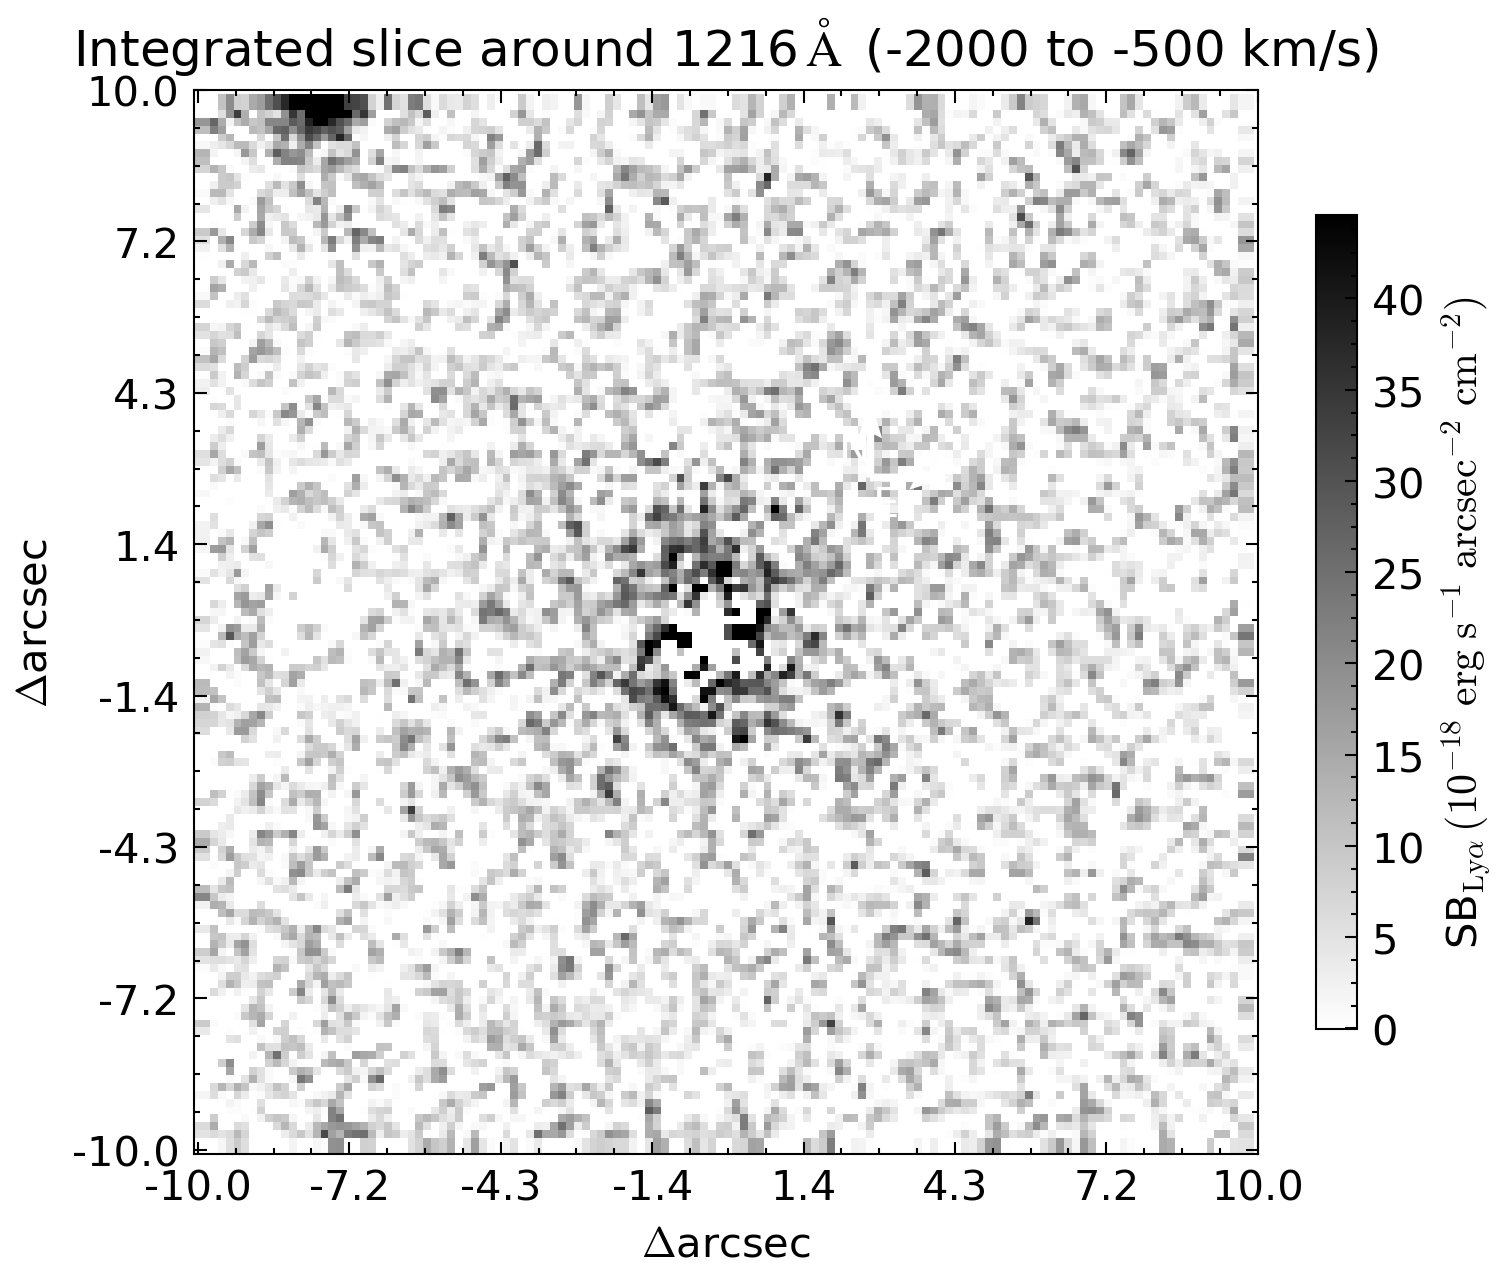

In [15]:

plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})
Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"
efactor=1e-2/0.04
_, med, std = sigma_clipped_stats(cspace_stack*efactor,maxiters=100)
pix_scale=[0.15,0.15]
fig, ax = imshow_ifu(cspace_stack*efactor,figsize = (5,5),dpi=300,pix_scale=pix_scale, cblabel = Lyau, colorbar=True, vrange = (-0.02, 5*std),cmap = "binary")
    
#s_coord3=wcsinfo.world_to_pixel(sc3)
#ax.plot(s_coord3[0],s_coord3[1],"+",c="r",ms=30,lw=0.1)
#for aregion in Aregions:
#    ax.add_artist(aregion.as_artist(facecolor='none', edgecolor='green'))
ns_coord=sc.to_pixel(wcssub)
#ax.plot(ns_coord[0],ns_coord[1],"+",c="g",ms=30,lw=0.1)
#ax.text(ns_coord[0]+2,ns_coord[1]-3
        #,"{}".format(sourcename),color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)


#ax.scatter(sc3.ra.value, sc3.dec.value, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')
#ax.text(sc3.ra.value, sc3.dec.value,"{}-{}".format(cubename,tag3),color="red",transform=ax.get_transform('world'),verticalalignment='bottom',horizontalalignment='right',fontsize=15)

#rbin1=13
#rbin2=20
inner=4.2
outer=6.2
#region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=cspace_stack.shape[0]/2,y=cspace_stack.shape[1]/2),inner_radius=inner/pix_scale[0],outer_radius=outer/pix_scale[0])
region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=cspace_stack.shape[0]/2,y=cspace_stack.shape[1]/2),inner_radius=rbin[rbin1]/pix_scale[0],outer_radius=rbin[rbin2]/pix_scale[0])
#ax.add_artist(region_annulus_pix.as_artist(facecolor='none', edgecolor='green'))
print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
# North arrow goes upward in y-direction (positive Dec)
#ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
#ax.text(x0+1, y0+1, 'N', color='black', ha='center', va='bottom')
# East arrow goes to the right in x-direction (negative RA)
#ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
#ax.text(x0-1, y0-1, 'E', color='black', ha='center', va='top')


#-------------------Reference scale setting----------------#
dT = 10  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcssub.pixel_to_world(start_x, start_y)
end_coord = wcssub.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

#ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='red', lw=2)
#ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='red', ha='center', va='bottom')

#ax.set_xlabel("R.A.")
#ax.set_ylabel("Dec.")
fig.savefig(KBSSpath+"/MUSEQSO/QSOs_r6_bright/stacked_img_blue.pdf")
ax.set_title(r"Integrated slice around {}$\rm\,\AA\,$ ({} to {} km/s)".format(1216,vlow,vup))

<function lya_model_2 at 0x7f85e63b1ef0>
highlighting annulus region in: 8.4 9.200000000000001 arcsec


(-0.1, 0.5)

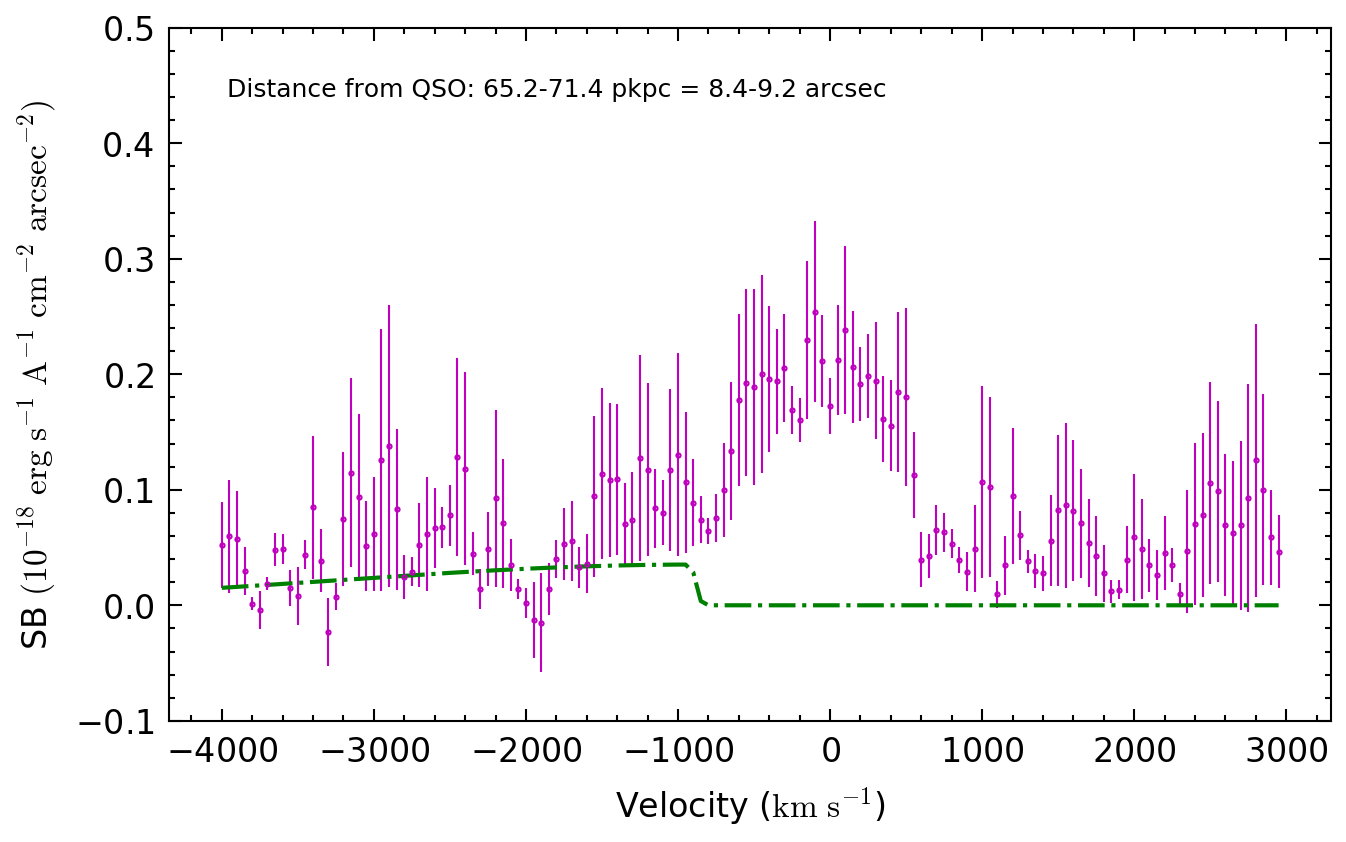

In [16]:
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(3.15).value/60
efactor=1e-2/0.04

fig, ax = plt.subplots(figsize=(5,3),dpi=300)

p0,p0sig=common_tools_yd.fit_lya_2(vstack1,cspace_specstack*efactor,specerr*efactor,absolute_sigma=False, all_p=True)

fitmodel0, lyamodel0, ndim0, p0, pcov0=common_tools_yd.lya_bestmod(vstack1,cspace_specstack*efactor,specerr*efactor, plot=False)

#ax.plot(vstack1,mod,"--C1",label="Full model")
ax.errorbar(vstack1,cspace_specstack*efactor,yerr=specerr*efactor,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
mod = lyamodel0(vstack1, *p0)
print(lyamodel0)
mod1 = common_tools_yd.skew_gauss(vstack1,*p0[:4])
mod2 = common_tools_yd.skew_gauss(vstack1, *p0[4:])
ax.plot(vstack1,mod1,"g",ls="-.")
#ax.plot(vstack1,mod2,"k",ls=":")

ax.text(0.05,0.9,f"Distance from QSO: {rbin[rbin1]*kpc_per_arcsec:.1f}-{rbin[rbin2]*kpc_per_arcsec:.1f} pkpc = {rbin[rbin1]:.1f}-{rbin[rbin2]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

#mod = common_tools_yd.skew_gauss(vstack1, *p0)
#ax.plot(vstack1,mod,"m",ls="--")
#ax.axhline(y=0,c="r")
#for sind in range(stackspec.shape[0]):
    #ax.errorbar(vstack1,stackspec[sind,:]*100,fmt="-o",mfc='none',ms=0.5,color="C{}".format(sind),ecolor="m",lw=0.5)
#ax.legend(loc="right")
ax.set_xlabel(r"Velocity ($\rm km~s^{-1}$)")
ax.set_ylabel(r"SB $\rm (10^{-18}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$")
print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
#ax.set_xlim([-3000,3000])
ax.set_ylim([-0.1,0.5])
#ax.text(0.05,0.85,string,transform=ax.transAxes,color="k",fontsize=6)
#ax.text(0.05,0.75,f"Distance from QSO: {ynew[xind]*kpc_per_arcsec:.1f} pkpc = {ynew[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

In [53]:
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})



kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60

spec
fig, ax = plt.subplots(figsize=(5,3),dpi=300)

p0,p0sig=common_tools_yd.fit_lya_2(vstack1,cspace_specstack*100,specerr*100,absolute_sigma=False, all_p=True)

fitmodel0, lyamodel0, ndim0, p0, pcov0=common_tools_yd.lya_bestmod(vstack1,cspace_specstack*100,specerr*100, plot=False)

#ax.plot(vstack1,mod,"--C1",label="Full model")
ax.errorbar(vstack1,cspace_specstack*100,yerr=specerr*100,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
mod = lyamodel0(vstack1, *p0)
print(lyamodel0)
mod1 = common_tools_yd.skew_gauss(vstack1,*p0[:4])
mod2 = common_tools_yd.skew_gauss(vstack1, *p0[4:])
ax.plot(vstack1,mod1,"g",ls="-.")
ax.plot(vstack1,mod2,"k",ls=":")

ax.text(0.05,0.9,f"Distance from QSO: {rbin[rbin1]*kpc_per_arcsec:.1f}-{rbin[rbin2]*kpc_per_arcsec:.1f} pkpc = {rbin[rbin1]:.1f}-{rbin[rbin2]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

#mod = common_tools_yd.skew_gauss(vstack1, *p0)
#ax.plot(vstack1,mod,"m",ls="--")
#ax.axhline(y=0,c="r")
#for sind in range(stackspec.shape[0]):
    #ax.errorbar(vstack1,stackspec[sind,:]*100,fmt="-o",mfc='none',ms=0.5,color="C{}".format(sind),ecolor="m",lw=0.5)
#ax.legend(loc="right")
ax.set_xlabel(r"Velocity ($\rm km~s^{-1}$)")
ax.set_ylabel(r"SB $\rm (10^{-18}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$")
print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
#ax.set_xlim([-3000,3000])
ax.set_ylim([-0.3,1])
#ax.text(0.05,0.85,string,transform=ax.transAxes,color="k",fontsize=6)
#ax.text(0.05,0.75,f"Distance from QSO: {ynew[xind]*kpc_per_arcsec:.1f} pkpc = {ynew[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

(<function common_tools_yd.fit_lya_05(vel, spec, spec_sig, all_p=False, absolute_sigma=False)>,
 <function common_tools_yd.sym_gauss(vel, v0, sigv, height, a0=None, a1=None, a2=None, a3=None, a4=None)>,
 3,
 array([ 2.03367047e+02,  5.02556733e+02,  0.00000000e+00,  2.49927911e+00,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03, -9.99900000e+03]),
 array([[ 5.82481825e+02, -1.00709144e+02, -9.99900000e+03,
         -5.24139126e-01, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03],
        [-1.00709144e+02,  5.55820427e+02, -9.99900000e+03,
         -2.13547336e+00, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03],
        [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03],
        [-5.24139126e-01, -2.13547336e+00, -9.99900000e+03,
          1.98062229e-02, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -

In [55]:
p0

array([-8.11135524e+01,  9.40166648e+02,  7.70879222e+00,  5.56151971e-01,
        5.34132956e+02,  7.25096840e+02, -2.57317023e+00,  1.14722095e+00])

In [431]:
2.*np.max(cspace_specstack)

0.021221714813292224

In [318]:
rbin

array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6, 3.9,
       4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. , 6.3])

In [319]:
region_annulus_sky = CircleAnnulusSkyRegion(center=sc,
                                            inner_radius=0.3 * u.arcsec,
                                            outer_radius=0.6 * u.arcsec)
region_annulus_pix = region_annulus_sky.to_pixel(wcssub)

In [325]:
wcssub.pixel_scale_matrix*3600

array([[-0.2,  0. ],
       [ 0. ,  0.2]])

In [348]:
wcsinfo.pixel_scale_matrix[1,1]*3600

0.200000000000016

In [349]:
pixel_scale

-0.200000000000016